In [1]:
# --- Parámetros (se pueden sobreescribir en CI) ---
RUN_DATE = "2025-09-15"
SEASON   = "2025_26"
MATCHDAY = None
MODEL_VERSION = "xgb-local"

# --- Rutas coherentes local/CI ---
from pathlib import Path
ROOT   = Path.cwd()
DATA   = ROOT / "data"
RAW    = DATA / "01_raw"
PROC   = DATA / "02_processed"
FEAT   = DATA / "03_features"
MODELS = DATA / "04_models"
OUT    = ROOT / "outputs"

for p in [RAW, PROC, FEAT, MODELS, OUT]:
    p.mkdir(parents=True, exist_ok=True)

# Reproducibilidad
import random, numpy as np
random.seed(42); np.random.seed(42)

In [2]:
import pandas as pd, json

def load_feat(name: str):
    return pd.read_parquet(FEAT / name)

def save_model(obj, name: str):
    from joblib import dump
    MODELS.mkdir(parents=True, exist_ok=True)
    dump(obj, MODELS / name)

def save_predictions(df: pd.DataFrame, name: str = "predictions_next.csv"):
    OUT.mkdir(parents=True, exist_ok=True)
    df.to_csv(OUT / name, index=False)

def save_json(obj, name: str = "metrics_overview.json"):
    OUT.mkdir(parents=True, exist_ok=True)
    with open(OUT / name, "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

# **MODELOS**

In [ ]:
import json
from collections import defaultdict
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import accuracy_score, log_loss
from imblearn.over_sampling import SMOTE
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

# **PREDICCIÓN: Logistic Regression multinomial**

In [4]:
IN_PATH = FEAT / "df_final.parquet"
df = pd.read_parquet(IN_PATH)

print("Leído:", IN_PATH, "· filas=", len(df), "· cols=", df.shape[1])
df.head(2)

Leído: /content/data/03_features/df_final.parquet · filas= 7271 · cols= 74


,B365A,B365D,B365H,Date,FTR,HomeTeam_norm,AwayTeam_norm,h_elo,a_elo,Season,...,a_squad_size_prev_season,a_pct_foreigners_prev_season,has_xg_data,target,home_playstyle_defensivo,home_playstyle_equilibrado,home_playstyle_ofensivo,away_playstyle_defensivo,away_playstyle_equilibrado,away_playstyle_ofensivo
0,6.00,3.6,1.57,2006-08-26,H,valencia,betis,1857.375122,1726.076904,2006,...,33.0,24.24,0,2.0,False,False,True,True,False,False
1,3.75,3.2,2.00,2006-08-27,D,ath bilbao,sociedad,1755.359253,1701.137573,2006,...,31.0,22.58,0,1.0,False,True,False,False,True,False


Sin SMOTE:

In [5]:
# =========================
# PREDICCIÓN (BASELINE, sin SMOTE) + B365 + export (sin df_old)
# =========================

# --- Parámetros del rango a predecir ---
PRED_SEASON = 2025
start_date  = pd.to_datetime("2025-09-19").date()
end_date    = pd.to_datetime("2025-09-21").date()

# --- Normaliza fechas en df (df_final ya cargado) ---
df = df.copy()
df["Date"] = pd.to_datetime(df["Date"]).dt.date

# --- Índices a predecir (orden estable por fecha+índice) ---
mask_pred = (
    (df["Season"] == PRED_SEASON) &
    (df["Date"] >= start_date) &
    (df["Date"] <= end_date)
)
pred_idx_sorted = (
    df.loc[mask_pred]
      .assign(_idx=lambda x: x.index)
      .sort_values(["Date","_idx"]).index.tolist()
)
print(f"[BASE] partidos a predecir: {len(pred_idx_sorted)} en {start_date}–{end_date}")

# --- X,y evitando fugas (añadimos los nombres para NO usarlos como features) ---
drop_cols = [
    'FTR','target','Date','has_xg_data','overround','pimp2','B365D',
    'a_squad_size_prev_season','away_form_gd_6','home_form_gd_6',
    'HomeTeam_norm','AwayTeam_norm',  # <- NUEVO: excluir nombres del modelo
    'row_id'                          # <- por si existiera
]
drop_cols = [c for c in drop_cols if c in df.columns]

X = df.drop(columns=drop_cols)
y = df["target"]

mask_train = (~mask_pred) & (y.notna())
X_train = X.loc[mask_train].copy()
y_train = y.loc[mask_train].astype(int)

# X de predicción en el MISMO orden que exportaremos
X_pred  = X.loc[pred_idx_sorted].copy()

# quitar 'Season' si queda y alinear columnas
for D in (X_train, X_pred):
    if "Season" in D.columns:
        D.drop(columns=["Season"], inplace=True)
X_pred = X_pred.reindex(columns=X_train.columns, fill_value=np.nan)

# --- Modelo baseline ---
pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler()),
    ("logreg",  LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42))
])
pipe.fit(X_train, y_train)

# --- Predicción (ya en orden final) ---
proba_pred  = pipe.predict_proba(X_pred)
pred_labels = pipe.predict(X_pred)

# map de clases a 1X2
class_map = {0:"A", 1:"D", 2:"H"}
classes    = list(pipe.named_steps["logreg"].classes_)  # e.g. [0,1,2]
pred_1x2   = pd.Series(pred_labels).map(class_map).values

# probabilidades por H/D/A robustas a orden de clases
proba_df = pd.DataFrame(proba_pred, columns=[class_map[c] for c in classes])
for lab in ["H","D","A"]:
    if lab not in proba_df.columns:
        proba_df[lab] = np.nan
proba_df = proba_df[["H","D","A"]].reset_index(drop=True)

# --- Nombres, cuotas y fechas directamente de df (ordenadas como pred_idx_sorted) ---
need_cols = ["Date","HomeTeam_norm","AwayTeam_norm","B365H","B365D","B365A"]
missing = [c for c in need_cols if c not in df.columns]
assert not missing, f"Faltan columnas en df_final: {missing}"

meta_ord = df.loc[pred_idx_sorted, need_cols].copy().reset_index(drop=True)

# probabilidades implícitas y overround
with np.errstate(divide="ignore", invalid="ignore"):
    inv = 1.0 / meta_ord[["B365H","B365D","B365A"]]
overround = inv.sum(axis=1)
imp = inv.div(overround, axis=0)
imp.columns = ["Imp_H","Imp_D","Imp_A"]

# --- Resultado final + export ---
out_base = pd.concat([
    meta_ord[["Date","HomeTeam_norm","AwayTeam_norm","B365H","B365D","B365A"]],
    pd.Series(pred_1x2, name="Pred"),
    proba_df.rename(columns={"H":"Prob_H","D":"Prob_D","A":"Prob_A"}),
    imp,
    overround.rename("Overround"),
], axis=1)

# Asegura carpeta OUT
try:
    OUT
except NameError:
    ROOT = Path(".")
    OUT = ROOT / "outputs"
OUT.mkdir(parents=True, exist_ok=True)

suffix = f"{PRED_SEASON}_{start_date}_{end_date}"

# con sufijo (histórico)
out_base.to_csv( OUT / f"predictions_{suffix}_base.csv", index=False)
out_base.to_json(OUT / f"predictions_{suffix}_base.json", orient="records", force_ascii=False, indent=2)

# “current” (para la app)
out_base.to_csv( OUT / "predictions_current_base.csv", index=False)
out_base.to_json(OUT / "predictions_current_base.json", orient="records", force_ascii=False, indent=2)

display(out_base.head(10))
print("Exportado BASE en:", OUT)

[BASE] partidos a predecir: 10 en 2025-09-19–2025-09-21


,Date,HomeTeam_norm,AwayTeam_norm,B365H,B365D,B365A,Pred,Prob_H,Prob_D,Prob_A,Imp_H,Imp_D,Imp_A,Overround
0,2025-09-19,betis,sociedad,2.05,3.10,4.00,H,0.408542,0.323314,0.268144,0.460026,0.304211,0.235763,1.060386
1,2025-09-20,girona,levante,1.90,3.50,3.90,H,0.406479,0.350893,0.242628,0.492602,0.267412,0.239986,1.068440
2,2025-09-20,real madrid,espanol,1.22,7.00,11.00,H,0.811867,0.136805,0.051328,0.778092,0.135610,0.086297,1.053438
3,2025-09-20,alaves,sevilla,2.40,3.10,3.00,D,0.308216,0.392619,0.299165,0.388471,0.300752,0.310777,1.072581
4,2025-09-20,villarreal,osasuna,1.53,4.10,5.75,H,0.607126,0.262557,0.130317,0.610032,0.227646,0.162322,1.071410
5,2025-09-20,valencia,ath bilbao,3.20,3.00,2.45,D,0.233103,0.434462,0.332435,0.296491,0.316257,0.387253,1.053997
6,2025-09-21,elche,oviedo,2.05,3.00,4.10,H,0.373651,0.349079,0.277270,0.458015,0.312977,0.229008,1.065041
7,2025-09-21,vallecano,celta,2.30,3.30,3.10,H,0.400853,0.322284,0.276864,0.410020,0.285772,0.304208,1.060394
8,2025-09-21,mallorca,ath madrid,5.00,3.50,1.75,A,0.203928,0.309176,0.486896,0.189189,0.270270,0.540541,1.057143
9,2025-09-21,barcelona,getafe,1.25,6.25,9.50,H,0.818260,0.129387,0.052354,0.750988,0.150198,0.098814,1.065263


Exportado BASE en: /content/outputs


Con SMOTE:

In [6]:
# =========================
# PREDICCIÓN (SMOTE) + B365 + export (sin df_old)
# =========================

# --- Parámetros del rango a predecir (usa los mismos que en baseline) ---
PRED_SEASON = 2025
start_date  = pd.to_datetime("2025-09-19").date()
end_date    = pd.to_datetime("2025-09-21").date()

# --- Normaliza fechas en df (df_final ya cargado) ---
df = df.copy()
df["Date"] = pd.to_datetime(df["Date"]).dt.date

# --- Índices a predecir (orden estable por fecha+índice) ---
mask_pred = (
    (df["Season"] == PRED_SEASON) &
    (df["Date"] >= start_date) &
    (df["Date"] <= end_date)
)
pred_idx_sorted = (
    df.loc[mask_pred]
      .assign(_idx=lambda x: x.index)
      .sort_values(["Date","_idx"]).index.tolist()
)
print(f"[SMOTE] partidos a predecir: {len(pred_idx_sorted)} en {start_date}–{end_date}")

# --- X,y evitando fugas (excluye nombres de equipos de las features) ---
drop_cols = [
    'FTR','target','Date','has_xg_data','overround','pimp2','B365D',
    'a_squad_size_prev_season','away_form_gd_6','home_form_gd_6',
    'HomeTeam_norm','AwayTeam_norm',  # <- excluir nombres del modelo
    'row_id'
]
drop_cols = [c for c in drop_cols if c in df.columns]

X = df.drop(columns=drop_cols)
y = df["target"]

mask_train = (~mask_pred) & (y.notna())
X_train = X.loc[mask_train].copy()
y_train = y.loc[mask_train].astype(int)

# X de predicción en el MISMO orden de export
X_pred  = X.loc[pred_idx_sorted].copy()

# quitar 'Season' si queda y alinear columnas
for D in (X_train, X_pred):
    if "Season" in D.columns:
        D.drop(columns=["Season"], inplace=True)
X_pred = X_pred.reindex(columns=X_train.columns, fill_value=np.nan)

# --- Modelo SMOTE ---
pipe_sm = ImbPipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler()),
    ("smote",   SMOTE(random_state=42)),
    ("logreg",  LogisticRegression(solver="saga", penalty="l2", max_iter=1000, random_state=42))
])
pipe_sm.fit(X_train, y_train)

# --- Predicción (ya en orden final) ---
proba_pred_sm  = pipe_sm.predict_proba(X_pred)
pred_labels_sm = pipe_sm.predict(X_pred)

class_map = {0:"A", 1:"D", 2:"H"}
classes_sm = list(pipe_sm.named_steps["logreg"].classes_)
pred_1x2_sm = pd.Series(pred_labels_sm).map(class_map).values

proba_df_sm = pd.DataFrame(proba_pred_sm, columns=[class_map[c] for c in classes_sm])
for lab in ["H","D","A"]:
    if lab not in proba_df_sm.columns:
        proba_df_sm[lab] = np.nan
proba_df_sm = proba_df_sm[["H","D","A"]].reset_index(drop=True)

# --- Nombres, cuotas y fechas directamente de df (orden pred_idx_sorted) ---
need_cols = ["Date","HomeTeam_norm","AwayTeam_norm","B365H","B365D","B365A"]
missing = [c for c in need_cols if c not in df.columns]
assert not missing, f"Faltan columnas en df_final: {missing}"

meta_ord = df.loc[pred_idx_sorted, need_cols].copy().reset_index(drop=True)

# probabilidades implícitas y overround
with np.errstate(divide="ignore", invalid="ignore"):
    inv = 1.0 / meta_ord[["B365H","B365D","B365A"]]
overround = inv.sum(axis=1)
imp = inv.div(overround, axis=0)
imp.columns = ["Imp_H","Imp_D","Imp_A"]

# --- Resultado final + export ---
out_sm = pd.concat([
    meta_ord[["Date","HomeTeam_norm","AwayTeam_norm","B365H","B365D","B365A"]],
    pd.Series(pred_1x2_sm, name="Pred"),
    proba_df_sm.rename(columns={"H":"Prob_H","D":"Prob_D","A":"Prob_A"}),
    imp,
    overround.rename("Overround"),
], axis=1)

# Asegura carpeta OUT (misma que baseline)
try:
    OUT
except NameError:
    ROOT = Path(".")
    OUT = ROOT / "outputs"
OUT.mkdir(parents=True, exist_ok=True)

suffix = f"{PRED_SEASON}_{start_date}_{end_date}"

# con sufijo (histórico)
out_sm.to_csv( OUT / f"predictions_{suffix}_smote.csv", index=False)
out_sm.to_json(OUT / f"predictions_{suffix}_smote.json", orient="records", force_ascii=False, indent=2)

# “current” (para la app)
out_sm.to_csv( OUT / "predictions_current_smote.csv", index=False)
out_sm.to_json(OUT / "predictions_current_smote.json", orient="records", force_ascii=False, indent=2)

display(out_sm.head(10))
print("Exportado SMOTE en:", OUT)

[SMOTE] partidos a predecir: 10 en 2025-09-19–2025-09-21


,Date,HomeTeam_norm,AwayTeam_norm,B365H,B365D,B365A,Pred,Prob_H,Prob_D,Prob_A,Imp_H,Imp_D,Imp_A,Overround
0,2025-09-19,betis,sociedad,2.05,3.10,4.00,D,0.247164,0.468492,0.284345,0.460026,0.304211,0.235763,1.060386
1,2025-09-20,girona,levante,1.90,3.50,3.90,D,0.275431,0.449404,0.275165,0.492602,0.267412,0.239986,1.068440
2,2025-09-20,real madrid,espanol,1.22,7.00,11.00,H,0.723960,0.211729,0.064311,0.778092,0.135610,0.086297,1.053438
3,2025-09-20,alaves,sevilla,2.40,3.10,3.00,D,0.179639,0.550759,0.269602,0.388471,0.300752,0.310777,1.072581
4,2025-09-20,villarreal,osasuna,1.53,4.10,5.75,H,0.481312,0.348460,0.170228,0.610032,0.227646,0.162322,1.071410
5,2025-09-20,valencia,ath bilbao,3.20,3.00,2.45,D,0.138001,0.528202,0.333797,0.296491,0.316257,0.387253,1.053997
6,2025-09-21,elche,oviedo,2.05,3.00,4.10,D,0.254901,0.422445,0.322654,0.458015,0.312977,0.229008,1.065041
7,2025-09-21,vallecano,celta,2.30,3.30,3.10,D,0.243360,0.459598,0.297042,0.410020,0.285772,0.304208,1.060394
8,2025-09-21,mallorca,ath madrid,5.00,3.50,1.75,A,0.123738,0.400692,0.475571,0.189189,0.270270,0.540541,1.057143
9,2025-09-21,barcelona,getafe,1.25,6.25,9.50,H,0.716049,0.218309,0.065642,0.750988,0.150198,0.098814,1.065263


Exportado SMOTE en: /content/outputs


# **EVALUACIÓN HISTÓRICA: Logistic Regression multinomial**

In [7]:
IN_PATH = FEAT / "df_final.parquet"
df = pd.read_parquet(IN_PATH)

Sin SMOTE:

In [8]:
# ===== Imports necesarios (por si no están ya arriba) =====

# ===== Eval: LogReg SIN SMOTE (excluyendo nombres de equipos y ids) =====
def run_logreg_eval_no_smote(
    df: pd.DataFrame,
    train_until_season: int = 2023,
    test_until_season: int | None = None,
    with_odds: bool = True,
    random_state: int = 42,
):
    """
    Train: Season <= train_until_season
    Test : Season >  train_until_season  (y si test_until_season no es None, Season <= test_until_season)
    Excluye columnas no predictoras (incluye HomeTeam_norm/AwayTeam_norm si están en df).
    """

    # --- columnas a excluir SIEMPRE de X ---
    drop_cols_common = [
        'FTR', 'target', 'Date', 'has_xg_data',
        'a_squad_size_prev_season', 'away_form_gd_6', 'home_form_gd_6',
        'HomeTeam_norm','AwayTeam_norm',   # <- NUEVO: fuera de las features
        'row_id',                          # <- si existe
    ]
    # --- columnas a excluir según modo con/sin cuotas ---
    if with_odds:
        drop_cols_mode = ['overround', 'pimp2', 'B365D']
    else:
        drop_cols_mode = [
            'fase_temporada_inicio','fase_temporada_mitad',
            'B365H','B365D','B365A','overround','pimp1','pimpx','pimp2'
        ]
    drop_cols = list(dict.fromkeys(drop_cols_common + drop_cols_mode))

    # --- X e y; filtrado de válidos ---
    y_all = df['target']
    X_all = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    valid = y_all.notna()
    if with_odds:
        # Si entrenas "con cuotas", exige al menos H y A (D la quitamos de X)
        for c in ['B365H','B365A']:
            if c in X_all.columns:
                valid &= X_all[c].notna()
    valid &= X_all.notna().all(axis=1)

    X_all = X_all.loc[valid].copy()
    y_all = y_all.loc[valid].astype(int)

    if 'Season' not in X_all.columns:
        raise ValueError("Falta la columna 'Season' en X para hacer el split temporal.")

    # --- split temporal ---
    train_mask = X_all['Season'] <= train_until_season
    test_mask  = X_all['Season'] >  train_until_season
    if test_until_season is not None:
        test_mask &= (X_all['Season'] <= test_until_season)

    X_train = X_all.loc[train_mask].drop(columns=['Season'])
    y_train = y_all.loc[train_mask]

    X_test  = X_all.loc[test_mask].drop(columns=['Season'])
    y_test  = y_all.loc[test_mask]
    idx_test = X_all.loc[test_mask].index

    if len(X_train) == 0 or len(np.unique(y_train)) < 2:
        raise ValueError("TRAIN vacío o con <2 clases. Revisa filtros/temporadas.")

    # --- escalado + modelo ---
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test) if len(X_test) else None

    model = LogisticRegression(
        solver='saga', penalty='l2', max_iter=1000, random_state=random_state
    )
    model.fit(X_train_scaled, y_train)
    classes_used = model.classes_

    # --- métricas train ---
    ytr_pred  = model.predict(X_train_scaled)
    ytr_proba = model.predict_proba(X_train_scaled)
    ytr_bin   = label_binarize(y_train, classes=classes_used)
    brier_tr  = np.mean(np.sum((ytr_proba - ytr_bin)**2, axis=1))
    acc_tr    = accuracy_score(y_train, ytr_pred)
    ll_tr     = log_loss(y_train, ytr_proba, labels=classes_used)
    metrics_train = {
        "accuracy": float(acc_tr),
        "log_loss": float(ll_tr),
        "brier": float(brier_tr),
        "n_train": int(len(y_train))
    }

    # --- métricas test ---
    metrics_test, yte_pred, yte_proba = None, None, None
    if len(X_test):
        yte_pred  = model.predict(X_test_scaled)
        yte_proba = model.predict_proba(X_test_scaled)
        yte_bin   = label_binarize(y_test, classes=classes_used)
        brier_te  = np.mean(np.sum((yte_proba - yte_bin)**2, axis=1))
        acc_te    = accuracy_score(y_test, yte_pred)
        ll_te     = log_loss(y_test, yte_proba, labels=classes_used)
        metrics_test = {
            "accuracy": float(acc_te),
            "log_loss": float(ll_te),
            "brier": float(brier_te),
            "n_test": int(len(y_test)),
            "season_min": int(X_all.loc[test_mask, 'Season'].min()),
            "season_max": int(X_all.loc[test_mask, 'Season'].max())
        }
    else:
        print("⚠️ TEST vacío tras filtrar (no hay partidos jugados en el rango de test).")

    test_range_txt = (f"{train_until_season+1}..{test_until_season}"
                      if test_until_season is not None else f">{train_until_season}")
    print("Logistic Regression (sin SMOTE)", "(con cuotas)" if with_odds else "(sin cuotas)")
    print("\n=== Train ==="); print(metrics_train)
    print(f"\n=== Test (Seasons {test_range_txt}) ===")
    print(metrics_test if metrics_test else "Sin test disponible.")

    return model, scaler, (metrics_train, metrics_test), y_test, yte_pred, yte_proba, idx_test


# ===== Bucle que guarda eval_grid.json y metrics_by_season.csv =====
ROOT = Path(".")
OUT = ROOT / "outputs"
OUT.mkdir(parents=True, exist_ok=True)

seasons_all = sorted(df["Season"].dropna().astype(int).unique())

rows = []
for test_season in seasons_all:
    train_until = test_season - 1
    if train_until < seasons_all[0]:
        continue

    try:
        _, _, (mtr_tr, mtr_te), *_ = run_logreg_eval_no_smote(
            df,
            train_until_season=train_until,
            test_until_season=test_season,
            with_odds=True,
            random_state=42
        )
        if mtr_te is None:
            continue

        rows.append({
            "train_until": int(train_until),
            "test_season": int(test_season),
            "metrics_train": {
                "accuracy": float(mtr_tr["accuracy"]),
                "log_loss": float(mtr_tr["log_loss"]),
                "brier":    float(mtr_tr["brier"]),
                "n_train":  int(mtr_tr["n_train"]),
            },
            "metrics_test": {
                "accuracy": float(mtr_te["accuracy"]),
                "log_loss": float(mtr_te["log_loss"]),
                "brier":    float(mtr_te["brier"]),
                "n_test":   int(mtr_te["n_test"]),
                "season_min": int(mtr_te["season_min"]),
                "season_max": int(mtr_te["season_max"]),
            }
        })
    except Exception as e:
        print(f"[SKIP] test={test_season} → {e}")

with open(OUT / "eval_grid.json", "w", encoding="utf-8") as f:
    json.dump(rows, f, ensure_ascii=False, indent=2)

if rows:
    flat = []
    for r in rows:
        te = r["metrics_test"]
        flat.append({
            "test_season": r["test_season"],
            "train_until": r["train_until"],
            "acc_test":    te["accuracy"],
            "logloss_test":te["log_loss"],
            "brier_test":  te["brier"],
            "n_test":      te["n_test"],
        })
    pd.DataFrame(flat).sort_values("test_season").to_csv(
        OUT / "metrics_by_season.csv", index=False
    )

print(f"Guardados:\n- {OUT/'eval_grid.json'}\n- {OUT/'metrics_by_season.csv'}")

Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.6105263157894737, 'log_loss': 0.8529715015512208, 'brier': 0.5126050979185605, 'n_train': 380}

=== Test (Seasons 2007..2007) ===
{'accuracy': 0.4131578947368421, 'log_loss': 1.2357788018071167, 'brier': 0.7108253532823114, 'n_test': 380, 'season_min': 2007, 'season_max': 2007}
Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5552631578947368, 'log_loss': 0.92320990288169, 'brier': 0.5525509324329174, 'n_train': 760}

=== Test (Seasons 2008..2008) ===
{'accuracy': 0.4789473684210526, 'log_loss': 1.0902924033829702, 'brier': 0.6481976863657879, 'n_test': 380, 'season_min': 2008, 'season_max': 2008}
Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5491228070175439, 'log_loss': 0.9354323737003613, 'brier': 0.5585766915416096, 'n_train': 1140}

=== Test (Seasons 2009..2009) ===
{'accuracy': 0.55, 'log_loss': 0.969389177295256, 'brier': 0.5716061373746928, 'n_test':

In [9]:
# LOCAL
model, scaler, (mtr_tr, mtr_te), y_test, y_pred, y_proba, idx_test = \
    run_logreg_eval_no_smote(df, train_until_season=2023, test_until_season=2024, with_odds=True)

Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5489766081871345, 'log_loss': 0.9487394010473583, 'brier': 0.5629520762618124, 'n_train': 6840}

=== Test (Seasons 2024..2024) ===
{'accuracy': 0.5736842105263158, 'log_loss': 0.9558871484638822, 'brier': 0.5646711693258986, 'n_test': 380, 'season_min': 2024, 'season_max': 2024}


Con SMOTE:

In [10]:
def run_logreg_eval(
    df: pd.DataFrame,
    train_until_season: int = 2023,
    test_until_season: int | None = None,
    with_odds: bool = True,
    random_state: int = 42,
):
    """
    Regresión logística con SMOTE + escalado.
      - Train: Season <= train_until_season
      - Test : Season >  train_until_season (y si test_until_season no es None, Season <= test_until_season)
      - Si with_odds=True, exige B365H/B365A no NaN.
      - Descarta filas con NaN en features.
    Returns:
      model, scaler, (metrics_train, metrics_test),
      y_test (o None), y_pred_test (o None), proba_test (o None), idx_test (o None)
    """

    # --- EXCLUIR SIEMPRE de X (añadido Home/Away names y row_id) ---
    drop_cols_common = [
        'FTR', 'target', 'Date', 'has_xg_data',
        'a_squad_size_prev_season', 'away_form_gd_6', 'home_form_gd_6',
        'HomeTeam_norm', 'AwayTeam_norm',   # <-- NUEVO: fuera del modelo
        'row_id',                           # <-- NUEVO: por si existe
    ]
    if with_odds:
        drop_cols_mode = ['overround', 'pimp2', 'B365D']
    else:
        drop_cols_mode = ['fase_temporada_inicio','fase_temporada_mitad',
                          'B365H','B365D','B365A','overround','pimp1','pimpx','pimp2']
    drop_cols = list(dict.fromkeys(drop_cols_common + drop_cols_mode))

    # --- X e y; filtrado de válidos ---
    y_all = df['target']
    X_all = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    valid_mask = y_all.notna()
    if with_odds:
        for c in ['B365H', 'B365A']:
            if c in X_all.columns:
                valid_mask &= X_all[c].notna()
    valid_mask &= X_all.notna().all(axis=1)

    X_all = X_all.loc[valid_mask].copy()
    y_all = y_all.loc[valid_mask].astype(int)

    if 'Season' not in X_all.columns:
        raise ValueError("Falta la columna 'Season' para hacer el split temporal.")

    # --- split temporal ---
    train_mask = X_all['Season'] <= train_until_season
    test_mask  = X_all['Season'] >  train_until_season
    if test_until_season is not None:
        test_mask &= (X_all['Season'] <= test_until_season)

    X_train = X_all.loc[train_mask].drop(columns=['Season'])
    y_train = y_all.loc[train_mask]

    X_test  = X_all.loc[test_mask].drop(columns=['Season'])
    y_test  = y_all.loc[test_mask]
    idx_test = X_all.loc[test_mask].index

    if len(X_train) == 0 or len(np.unique(y_train)) < 2:
        raise ValueError("TRAIN vacío o con menos de 2 clases. Revisa filtros/temporadas.")

    # --- escalado ---
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test) if len(X_test) else None

    # --- SMOTE robusto ---
    _, counts = np.unique(y_train, return_counts=True)
    min_count = int(counts.min())
    if min_count <= 1:
        X_train_res, y_train_res = X_train_scaled, y_train
    else:
        k = max(1, min(5, min_count - 1))
        try:
            smote = SMOTE(random_state=random_state, k_neighbors=k)
            X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
        except Exception:
            X_train_res, y_train_res = X_train_scaled, y_train

    # --- modelo ---
    model = LogisticRegression(
        solver='saga', penalty='l2', max_iter=1000, random_state=random_state
    )
    model.fit(X_train_res, y_train_res)
    classes_used = model.classes_

    # --- métricas train ---
    ytr_pred  = model.predict(X_train_scaled)
    ytr_proba = model.predict_proba(X_train_scaled)
    ytr_bin   = label_binarize(y_train, classes=classes_used)
    brier_tr  = float(np.mean(np.sum((ytr_proba - ytr_bin) ** 2, axis=1)))
    acc_tr    = float(accuracy_score(y_train, ytr_pred))
    ll_tr     = float(log_loss(y_train, ytr_proba, labels=classes_used))
    metrics_train = {
        "accuracy": acc_tr, "log_loss": ll_tr, "brier": brier_tr, "n_train": int(len(y_train))
    }

    # --- métricas test ---
    metrics_test, yte_pred, yte_proba = None, None, None
    if len(X_test):
        yte_pred  = model.predict(X_test_scaled)
        yte_proba = model.predict_proba(X_test_scaled)
        yte_bin   = label_binarize(y_test, classes=classes_used)
        brier_te  = float(np.mean(np.sum((yte_proba - yte_bin) ** 2, axis=1)))
        acc_te    = float(accuracy_score(y_test, yte_pred))
        ll_te     = float(log_loss(y_test, yte_proba, labels=classes_used))
        metrics_test = {
            "accuracy": acc_te, "log_loss": ll_te, "brier": brier_te,
            "n_test": int(len(y_test)),
            "season_min": int(X_all.loc[test_mask, 'Season'].min()),
            "season_max": int(X_all.loc[test_mask, 'Season'].max())
        }
    else:
        print("⚠️ TEST vacío tras filtrar (no hay partidos jugados en el rango de test).")

    # --- reporte ---
    test_range_txt = (f"{train_until_season+1}..{test_until_season}"
                      if test_until_season is not None else f">{train_until_season}")
    print("Logistic Regression con SMOTE", "(con cuotas)" if with_odds else "(sin cuotas)")
    print("\n=== Train ==="); print(metrics_train)
    print(f"\n=== Test (Seasons {test_range_txt}) ===")
    print(metrics_test if metrics_test else "Sin test disponible.")

    return model, scaler, (metrics_train, metrics_test), y_test, yte_pred, yte_proba, idx_test


OUT = ROOT / "outputs"   # o ROOT/"outs"
OUT.mkdir(parents=True, exist_ok=True)

seasons_all = sorted(df["Season"].dropna().astype(int).unique())
rows_sm = []
for test_season in seasons_all:
    train_until = test_season - 1
    if train_until < seasons_all[0]:
        continue
    try:
        _, _, (mtr_tr, mtr_te), *_ = run_logreg_eval(
            df, train_until_season=train_until, test_until_season=test_season,
            with_odds=True, random_state=42
        )
        if mtr_te is None:
            continue
        rows_sm.append({
            "train_until": int(train_until),
            "test_season": int(test_season),
            "metrics_train": {
                "accuracy": float(mtr_tr["accuracy"]),
                "log_loss": float(mtr_tr["log_loss"]),
                "brier":    float(mtr_tr["brier"]),
                "n_train":  int(mtr_tr["n_train"]),
            },
            "metrics_test": {
                "accuracy": float(mtr_te["accuracy"]),
                "log_loss": float(mtr_te["log_loss"]),
                "brier":    float(mtr_te["brier"]),
                "n_test":   int(mtr_te["n_test"]),
                "season_min": int(mtr_te["season_min"]),
                "season_max": int(mtr_te["season_max"]),
            }
        })
    except Exception as e:
        print(f"[SMOTE SKIP] test={test_season} → {e}")

with open(OUT / "eval_grid_smote.json", "w", encoding="utf-8") as f:
    json.dump(rows_sm, f, ensure_ascii=False, indent=2)

if rows_sm:
    flat_sm = []
    for r in rows_sm:
        te = r["metrics_test"]
        flat_sm.append({
            "test_season": r["test_season"],
            "train_until": r["train_until"],
            "acc_test":    te["accuracy"],
            "logloss_test":te["log_loss"],
            "brier_test":  te["brier"],
            "n_test":      te["n_test"],
        })
    pd.DataFrame(flat_sm).sort_values("test_season").to_csv(
        OUT / "metrics_by_season_smote.csv", index=False
    )

print("Guardados: eval_grid_smote.json y metrics_by_season_smote.csv")

Logistic Regression con SMOTE (con cuotas)

=== Train ===
{'accuracy': 0.5894736842105263, 'log_loss': 0.8832490658508221, 'brier': 0.5275427649252558, 'n_train': 380}

=== Test (Seasons 2007..2007) ===
{'accuracy': 0.39473684210526316, 'log_loss': 1.346089386911231, 'brier': 0.7669058200418584, 'n_test': 380, 'season_min': 2007, 'season_max': 2007}
Logistic Regression con SMOTE (con cuotas)

=== Train ===
{'accuracy': 0.5236842105263158, 'log_loss': 0.9678056846957641, 'brier': 0.583388627171342, 'n_train': 760}

=== Test (Seasons 2008..2008) ===
{'accuracy': 0.4105263157894737, 'log_loss': 1.152795781932829, 'brier': 0.6946941510676069, 'n_test': 380, 'season_min': 2008, 'season_max': 2008}
Logistic Regression con SMOTE (con cuotas)

=== Train ===
{'accuracy': 0.5096491228070176, 'log_loss': 0.9774496807318865, 'brier': 0.5863852093317935, 'n_train': 1140}

=== Test (Seasons 2009..2009) ===
{'accuracy': 0.49736842105263157, 'log_loss': 1.0093613866181081, 'brier': 0.5996975343000819,

In [11]:
# LOCAL
model_sm, scaler_sm, (mtr_tr_sm, mtr_te_sm), y_test_sm, y_pred_sm, y_proba_sm, idx_test_sm = \
    run_logreg_eval(df, train_until_season=2023, test_until_season=2024, with_odds=True)

Logistic Regression con SMOTE (con cuotas)

=== Train ===
{'accuracy': 0.5043859649122807, 'log_loss': 0.9848871796512613, 'brier': 0.5864816514331854, 'n_train': 6840}

=== Test (Seasons 2024..2024) ===
{'accuracy': 0.5184210526315789, 'log_loss': 0.9921047463371278, 'brier': 0.5899477319521216, 'n_test': 380, 'season_min': 2024, 'season_max': 2024}


Con este modelo obtengo el mejor **Accuracy** (porcentaje de aciertos totales), pero esta métrica ignora como de seguras son esas esas predicciones.

$$
\text{Accuracy} = \frac{\text{Número de aciertos}}{\text{Número total de predicciones}}
$$

Para ello se utiliza el **Log Loss** (Cross-Entropy Loss), métrica que mide qué tan buenas son las probabilidades que predice mi modelo de clasificación. A esta métrica no solo le importa acertar la clase, sino cuán seguro está el modelo.

$$
\text{LogLoss} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{K} y_{ij} \cdot \log(p_{ij})
$$

donde:

- $y_{ij}$ = 1 si la clase real del ejemplo $i$ es la clase $j$, y 0 en caso contrario.
- $p_{ij}$ es la probabilidad predicha por el modelo de que el ejemplo $i$ pertenezca a la clase $j$.

Tener un Log Loss alto en este caso significaría dar una probabilidad alta a la clase incorrecta, o lo que es lo mismo, dar una probabilidad baja a la clase correcta.

Por último añadí también el **Brier Score**, que es una métrica que evalúa cuán cercanas están las probabilidades predichas por tu modelo respecto a la realidad, comparando la distribución de probabilidades contra la clase real (codificada en one-hot). Es como un error cuadrático medio (MSE) para probabilidades.

$$
\text{Brier Score} = \frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{K} (p_{ij} - y_{ij})^2
$$

donde:

- $N$ es el número de ejemplos.
- $K$ es el número de clases (en este caso 3: victoria local, empate, victoria visitante).
- $p_{ij}$ es la probabilidad predicha por el modelo de que el ejemplo $i$ pertenezca a la clase $j$.
- $y_{ij}$ es 1 si la clase real del ejemplo $i$ es la clase $j$, y 0 en caso contrario.

Un Brier Score de 0 significa que las probabilidades dadas por el modelo son perfectas, mientras que uno del 0.66 en nuestro caso sería un modelo completamente aleatorio.


## Selección de variables

La función `forward_selection` implementa un algoritmo clásico de selección de variables hacia adelante (**forward feature selection**) sobre un modelo de regresión logística multiclase con escalado de variables.

Va añadiendo sucesivamente la variable que mejor mejora el rendimiento del modelo (según accuracy o log_loss), una por una.





In [18]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import make_pipeline
# from sklearn.metrics import accuracy_score, log_loss
# import numpy as np

# def forward_selection(X, y, max_features=20, scoring='accuracy'):
#     selected_features = []
#     remaining_features = list(X.columns)
#     scores = []

#     for i in range(min(max_features, len(remaining_features))):
#         best_score = -np.inf if scoring == 'accuracy' else np.inf
#         best_feature = None

#         for feature in remaining_features:
#             current_features = selected_features + [feature]

#             model = make_pipeline(
#                 StandardScaler(),
#                 LogisticRegression(max_iter=1000, solver='lbfgs')
#             )

#             model.fit(X[current_features], y)
#             y_pred = model.predict(X[current_features])
#             y_proba = model.predict_proba(X[current_features])

#             if scoring == 'accuracy':
#                 score = accuracy_score(y, y_pred)
#                 if score > best_score:
#                     best_score = score
#                     best_feature = feature
#             elif scoring == 'log_loss':
#                 score = log_loss(y, y_proba)
#                 if score < best_score:
#                     best_score = score
#                     best_feature = feature
#             else:
#                 raise ValueError("scoring debe ser 'accuracy' o 'log_loss'.")

#         if best_feature is not None:
#             selected_features.append(best_feature)
#             remaining_features.remove(best_feature)
#             scores.append(best_score)

#         print(f"[{i+1}] Añadida: {best_feature} | Score: {best_score:.4f}")

#     return selected_features, scores

In [19]:
# selected, scores = forward_selection(X_train, y_train, max_features=81, scoring='accuracy')

In [20]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Suponemos que tienes las listas: selected (variables) y scores (métricas acumuladas)

# # Calcular diferencia respecto al valor anterior
# deltas = np.diff([0] + scores)
# colors = ['blue' if delta >= 0 else 'red' for delta in deltas]

# plt.figure(figsize=(12,6))
# bar_width = 0.6  # Reducir ancho de barra para separarlas
# indices = np.arange(len(selected))

# plt.bar(indices, scores, color=colors, width=bar_width)
# plt.xticks(indices, selected, rotation=90)
# plt.xlabel('Variables añadidas')
# plt.ylabel('Valor de la métrica')
# plt.title('Evolución del rendimiento al añadir variables')

# plt.ylim(min(scores) - 0.01, max(scores) + 0.01)
# plt.tight_layout()
# plt.show()


Se implementó un proceso de selección hacia adelante (forward selection) sobre el modelo de regresión logística con variables estandarizadas. Este procedimiento consiste en partir sin predictores y añadir, en cada iteración, la variable que mayor mejora produce en el rendimiento del modelo. Se evaluaron dos métricas complementarias como criterio de selección: el accuracy (para priorizar aciertos de clasificación) y el log loss (para priorizar la calibración de las probabilidades). Esta técnica permitió reducir la dimensionalidad del conjunto original y determinar el orden de relevancia de las variables desde el punto de vista predictivo.

# **Resultados**

## **MATRIZ DE CONFUSIÓN**

In [12]:
# --- IMPORTS NECESARIOS ---

# ---------- Split de TEST con tope de temporada ----------
def _prep_test_split(
    df: pd.DataFrame,
    train_until_season: int,
    with_odds: bool,
    test_until_season: int | None = None
):
    # Excluimos también los nombres y posibles IDs para que NO entren en X
    drop_common = [
        'FTR','target','Date','has_xg_data',
        'a_squad_size_prev_season','away_form_gd_6','home_form_gd_6',
        'HomeTeam_norm','AwayTeam_norm','row_id'  # <- añadido
    ]
    drop_mode = (['overround','pimp2','B365D'] if with_odds else
                 ['fase_temporada_inicio','fase_temporada_mitad',
                  'B365H','B365D','B365A','overround','pimp1','pimpx','pimp2'])
    drop_cols = list(dict.fromkeys(drop_common + drop_mode))

    y_all = df['target']
    X_all = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    # válidas: sin NaN en y ni en X; si with_odds, exige cuotas clave
    valid = y_all.notna()
    if with_odds:
        for c in ['B365H','B365A']:
            if c in X_all.columns:
                valid &= X_all[c].notna()
    valid &= X_all.notna().all(axis=1)

    X_all = X_all.loc[valid].copy()
    y_all = y_all.loc[valid].astype(int)

    if 'Season' not in X_all.columns:
        raise ValueError("Falta 'Season' para el split temporal.")

    test_mask  = X_all['Season'] > train_until_season
    if test_until_season is not None:
        test_mask &= (X_all['Season'] <= test_until_season)

    X_test = X_all.loc[test_mask].drop(columns=['Season'])
    y_test = y_all.loc[test_mask]
    return X_test, y_test

# ---------- Alinear columnas de X a las usadas en el fit ----------
def _align_to_fit_columns(X: pd.DataFrame, fitter, feature_names: list[str] | None = None) -> pd.DataFrame:
    """
    Alinea X para que tenga EXACTAMENTE las columnas usadas en el fit.
    - Usa feature_names si se proporcionan; si no, intenta fitter.feature_names_in_.
    - Elimina columnas extra.
    - Lanza error si faltan columnas del fit.
    """
    cols_fit = feature_names if feature_names is not None else getattr(fitter, "feature_names_in_", None)
    if cols_fit is None:
        return X  # si el scaler/model se entrenó con arrays numpy sin nombres

    cols_fit = list(cols_fit)
    missing = [c for c in cols_fit if c not in X.columns]
    extra   = [c for c in X.columns   if c not in cols_fit]
    if extra:
        X = X.drop(columns=extra)
    if missing:
        raise ValueError(
            "X_test no contiene columnas usadas al entrenar:\n"
            f"- Faltan: {missing}\n"
            "Asegúrate de usar el MISMO esquema (with_odds / drop_cols) que en el fit, "
            "o pasa explícitamente 'feature_names' del entrenamiento."
        )
    return X[cols_fit]

# ---------- Matriz de confusión con rango de test configurable ----------
def plot_confusion_for_logreg(
    df: pd.DataFrame,
    model,
    scaler,
    train_until_season: int = 2023,
    test_until_season: int | None = None,
    with_odds: bool = True,
    feature_names: list[str] | None = None   # opcional: forzar lista de features del fit
):
    # 1) reconstruir TEST
    X_test, y_test = _prep_test_split(
        df, train_until_season=train_until_season,
        with_odds=with_odds, test_until_season=test_until_season
    )
    if len(X_test) == 0:
        rango = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
        print(f"⚠️ No hay TEST disponible tras filtrar (Seasons {rango}).")
        return

    # 2) alinear columnas a las del fit
    X_test = _align_to_fit_columns(X_test, scaler, feature_names=feature_names)

    # 3) predecir
    X_test_scaled = scaler.transform(X_test)
    y_pred = model.predict(X_test_scaled)

    # 4) plot
    class2label = {0:'Away', 1:'Draw', 2:'Home'}
    classes_used = model.classes_
    display_labels = [class2label.get(c, str(c)) for c in classes_used]

    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        labels=classes_used,
        display_labels=display_labels,
        cmap='Blues', colorbar=False
    )
    rango = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
    plt.title(f'Confusion Matrix (Seasons {rango})')
    plt.tight_layout()
    plt.show()

# ---------- Grid de matrices por temporada (guarda JSON para la app) ----------
def build_confusion_grid(df: pd.DataFrame, out_dir: Path, model: str = "base", random_state: int = 42):
    """
    Genera matrices de confusión por temporada y las guarda en:
      outputs/confusion_grid_<model>.json
    - model: "base" (sin SMOTE) | "smote"
    - Split: train ≤ S-1, test = S
    - Usa with_odds=True
    """
    seasons_all = sorted(df["Season"].dropna().astype(int).unique())
    rows = []
    for test_season in seasons_all:
        train_until = test_season - 1
        if train_until < seasons_all[0]:
            continue

        try:
            if model == "base":
                _, _, (_, mtr_te), y_test, y_pred, _, _ = run_logreg_eval_no_smote(
                    df,
                    train_until_season=train_until,
                    test_until_season=test_season,
                    with_odds=True,
                    random_state=random_state
                )
            elif model == "smote":
                _, _, (_, mtr_te), y_test, y_pred, _, _ = run_logreg_eval(
                    df,
                    train_until_season=train_until,
                    test_until_season=test_season,
                    with_odds=True,
                    random_state=random_state
                )
            else:
                raise ValueError("model debe ser 'base' o 'smote'.")

            if (mtr_te is None) or (y_test is None) or (y_pred is None) or (len(y_test) == 0):
                continue

            # y_test / y_pred pueden venir como Series -> convertir
            y_true = np.asarray(y_test)
            y_hat  = np.asarray(y_pred)

            cm = confusion_matrix(y_true, y_hat, labels=[0, 1, 2]).tolist()  # 0=A,1=D,2=H
            rows.append({
                "model": model,
                "train_until": int(train_until),
                "test_season": int(test_season),
                "labels": ["A","D","H"],
                "matrix": cm,
                "n_test": int(mtr_te["n_test"])
            })
        except Exception as e:
            print(f"[CONF {model.upper()} SKIP] test={test_season} → {e}")

    out_path = out_dir / f"confusion_grid_{model}.json"
    out_path.write_text(json.dumps(rows, ensure_ascii=False, indent=2), encoding="utf-8")
    print(f"Guardado: {out_path}  ({len(rows)} temporadas)")

# --- EJECUCIÓN ---
# Asegúrate de tener OUT definido:
# OUT = ROOT / "outputs"
OUT.mkdir(parents=True, exist_ok=True)

build_confusion_grid(df, OUT, model="base")
build_confusion_grid(df, OUT, model="smote")

Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.6105263157894737, 'log_loss': 0.8529715015512208, 'brier': 0.5126050979185605, 'n_train': 380}

=== Test (Seasons 2007..2007) ===
{'accuracy': 0.4131578947368421, 'log_loss': 1.2357788018071167, 'brier': 0.7108253532823114, 'n_test': 380, 'season_min': 2007, 'season_max': 2007}
Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5552631578947368, 'log_loss': 0.92320990288169, 'brier': 0.5525509324329174, 'n_train': 760}

=== Test (Seasons 2008..2008) ===
{'accuracy': 0.4789473684210526, 'log_loss': 1.0902924033829702, 'brier': 0.6481976863657879, 'n_test': 380, 'season_min': 2008, 'season_max': 2008}
Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5491228070175439, 'log_loss': 0.9354323737003613, 'brier': 0.5585766915416096, 'n_train': 1140}

=== Test (Seasons 2009..2009) ===
{'accuracy': 0.55, 'log_loss': 0.969389177295256, 'brier': 0.5716061373746928, 'n_test':

In [14]:
# EJECUTAR EN LOCAL
# plot_confusion_for_logreg(df, model, scaler, train_until_season=2023, test_until_season=2024, with_odds=True)

## **METRICAS DE CLASIFICACIÓN**

In [15]:
# -------- split TEST con tope de temporada --------
def _prep_test_split(
    df: pd.DataFrame,
    train_until_season: int,
    with_odds: bool,
    test_until_season: int | None = None
):
    # Excluimos también nombres de equipo (y row_id si existiese) para que NO entren como features
    drop_common = [
        'FTR','target','Date','has_xg_data',
        'a_squad_size_prev_season','away_form_gd_6','home_form_gd_6',
        'HomeTeam_norm','AwayTeam_norm','row_id'
    ]
    drop_mode = (['overround','pimp2','B365D'] if with_odds else
                 ['fase_temporada_inicio','fase_temporada_mitad',
                  'B365H','B365D','B365A','overround','pimp1','pimpx','pimp2'])
    drop_cols = list(dict.fromkeys(drop_common + drop_mode))

    y_all = df['target']
    X_all = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    valid = y_all.notna()
    if with_odds:
        for c in ['B365H','B365A']:
            if c in X_all.columns:
                valid &= X_all[c].notna()
    valid &= X_all.notna().all(axis=1)

    X_all = X_all.loc[valid].copy()
    y_all = y_all.loc[valid].astype(int)

    if 'Season' not in X_all.columns:
        raise ValueError("Falta 'Season' para hacer el split temporal.")

    test_mask  = X_all['Season'] > train_until_season
    if test_until_season is not None:
        test_mask &= (X_all['Season'] <= test_until_season)

    X_test = X_all.loc[test_mask].drop(columns=['Season'])
    y_test = y_all.loc[test_mask]
    return X_test, y_test

# -------- alinear columnas a las usadas en el fit --------
def _align_to_fit_columns(X: pd.DataFrame, fitter, feature_names: list[str] | None = None) -> pd.DataFrame:
    cols_fit = feature_names if feature_names is not None else getattr(fitter, "feature_names_in_", None)
    if cols_fit is None:
        # si se entrenó con arrays, no hay nombres; asumimos que X ya coincide
        return X
    cols_fit = list(cols_fit)
    missing = [c for c in cols_fit if c not in X.columns]
    extra   = [c for c in X.columns   if c not in cols_fit]
    if extra:
        X = X.drop(columns=extra)
    if missing:
        raise ValueError(
            "X_test no contiene columnas usadas al entrenar:\n"
            f"- Faltan: {missing}\n"
            "Asegúrate de usar el MISMO esquema (with_odds / drop_cols) que en el fit, "
            "o pasa explícitamente 'feature_names' del entrenamiento."
        )
    return X[cols_fit]

# -------- classification_report con rango de test configurable --------
def print_classification_report_for_logreg(
    df: pd.DataFrame, model, scaler,
    train_until_season: int = 2023,
    test_until_season: int | None = None,
    with_odds: bool = True,
    digits: int = 3,
    feature_names: list[str] | None = None   # opcional: columnas del fit
):
    from sklearn.metrics import classification_report

    X_test, y_test = _prep_test_split(
        df, train_until_season=train_until_season,
        with_odds=with_odds, test_until_season=test_until_season
    )
    if len(X_test) == 0:
        rango = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
        print(f"⚠️ No hay TEST disponible tras filtrar (Seasons {rango}).")
        return

    # Alinear a columnas de entrenamiento
    X_test = _align_to_fit_columns(X_test, scaler, feature_names=feature_names)

    # Predecir
    X_test_scaled = scaler.transform(X_test)
    y_pred = model.predict(X_test_scaled)

    # Etiquetas (orden estable 0=A,1=D,2=H)
    class2label = {0:'Away', 1:'Draw', 2:'Home'}
    classes_used = getattr(model, "classes_", np.array([0,1,2]))
    classes_used = [c for c in [0,1,2] if c in classes_used]
    target_names = [class2label[c] for c in classes_used]

    print(
        classification_report(
            y_test, y_pred,
            labels=classes_used,
            target_names=target_names,
            zero_division=0,
            digits=digits
        )
    )

# EJECUTAR EN LOCAL
# print_classification_report_for_logreg(df, model, scaler, train_until_season=2024, test_until_season=2025, with_odds=True)

def build_classification_grid(
    df: pd.DataFrame,
    out_dir: Path,
    model: str = "base",       # "base" (sin SMOTE) | "smote"
    with_odds: bool = True,    # como acordamos para la app
    random_state: int = 42
):
    """
    Exporta métricas de clasificación por temporada (train ≤ S-1, test = S).
    Guarda: outputs/classification_grid_<model>.json
            outputs/classification_by_season_<model>.csv (resumen tabular)
    """
    from sklearn.metrics import classification_report

    label_name = {0:"A", 1:"D", 2:"H"}  # tu codificación

    seasons_all = sorted(df["Season"].dropna().astype(int).unique())
    rows = []
    flat = []

    for test_season in seasons_all:
        train_until = test_season - 1
        if train_until < seasons_all[0]:
            continue

        try:
            if model == "base":
                _, _, (_, mtr_te), y_test, y_pred, _, _ = run_logreg_eval_no_smote(
                    df,
                    train_until_season=train_until,
                    test_until_season=test_season,
                    with_odds=with_odds,
                    random_state=random_state
                )
            else:
                _, _, (_, mtr_te), y_test, y_pred, _, _ = run_logreg_eval(
                    df,
                    train_until_season=train_until,
                    test_until_season=test_season,
                    with_odds=with_odds,
                    random_state=random_state
                )

            if (mtr_te is None) or (y_test is None) or (y_pred is None) or (len(y_test) == 0):
                continue

            # Orden de clases estable basado en el modelo (0,1,2)
            classes_used = getattr(model, "classes_", np.array([0,1,2]))
            classes_used = [c for c in [0,1,2] if c in classes_used]
            target_names = [label_name[c] for c in classes_used]

            rep = classification_report(
                y_test, y_pred,
                labels=classes_used,
                target_names=target_names,
                output_dict=True,
                zero_division=0
            )

            per_class = {}
            for c in classes_used:
                nm = label_name[c]
                if nm in rep:
                    per_class[nm] = {
                        "precision": float(rep[nm]["precision"]),
                        "recall":    float(rep[nm]["recall"]),
                        "f1":        float(rep[nm]["f1-score"]),
                        "support":   int(rep[nm]["support"]),
                    }

            overall = {
                "accuracy":     float(rep.get("accuracy", mtr_te.get("accuracy", float("nan")))),
                "macro_avg": {
                    "precision": float(rep["macro avg"]["precision"]),
                    "recall":    float(rep["macro avg"]["recall"]),
                    "f1":        float(rep["macro avg"]["f1-score"]),
                    "support":   int(rep["macro avg"]["support"]),
                },
                "weighted_avg": {
                    "precision": float(rep["weighted avg"]["precision"]),
                    "recall":    float(rep["weighted avg"]["recall"]),
                    "f1":        float(rep["weighted avg"]["f1-score"]),
                    "support":   int(rep["weighted avg"]["support"]),
                },
                "n_test": int(mtr_te["n_test"]),
            }

            rows.append({
                "model": model,
                "train_until": int(train_until),
                "test_season": int(test_season),
                "per_class": per_class,
                "overall": overall,
            })

            row_flat = {
                "test_season": int(test_season),
                "train_until": int(train_until),
                "accuracy": overall["accuracy"],
                "macro_f1": overall["macro_avg"]["f1"],
                "n_test": overall["n_test"],
            }
            for nm in ["A","D","H"]:
                if nm in per_class:
                    row_flat[f"precision_{nm}"] = per_class[nm]["precision"]
                    row_flat[f"recall_{nm}"]    = per_class[nm]["recall"]
                    row_flat[f"f1_{nm}"]        = per_class[nm]["f1"]
                    row_flat[f"support_{nm}"]   = per_class[nm]["support"]
            flat.append(row_flat)

        except Exception as e:
            print(f"[CLASS {model.upper()} SKIP] test={test_season} → {e}")

    out_dir.mkdir(parents=True, exist_ok=True)
    (out_dir / f"classification_grid_{model}.json").write_text(
        json.dumps(rows, ensure_ascii=False, indent=2),
        encoding="utf-8"
    )
    print(f"Guardado: {out_dir / f'classification_grid_{model}.json'}  ({len(rows)} temporadas)")

    if flat:
        pd.DataFrame(flat).sort_values("test_season").to_csv(
            out_dir / f"classification_by_season_{model}.csv", index=False
        )
        print(f"Guardado: {out_dir / f'classification_by_season_{model}.csv'}")

# --- EJECUCIÓN ---
OUT.mkdir(parents=True, exist_ok=True)

# Modelo base (sin SMOTE)
build_classification_grid(df, OUT, model="base", with_odds=True)

# También SMOTE:
build_classification_grid(df, OUT, model="smote", with_odds=True)

Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.6105263157894737, 'log_loss': 0.8529715015512208, 'brier': 0.5126050979185605, 'n_train': 380}

=== Test (Seasons 2007..2007) ===
{'accuracy': 0.4131578947368421, 'log_loss': 1.2357788018071167, 'brier': 0.7108253532823114, 'n_test': 380, 'season_min': 2007, 'season_max': 2007}
Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5552631578947368, 'log_loss': 0.92320990288169, 'brier': 0.5525509324329174, 'n_train': 760}

=== Test (Seasons 2008..2008) ===
{'accuracy': 0.4789473684210526, 'log_loss': 1.0902924033829702, 'brier': 0.6481976863657879, 'n_test': 380, 'season_min': 2008, 'season_max': 2008}
Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5491228070175439, 'log_loss': 0.9354323737003613, 'brier': 0.5585766915416096, 'n_train': 1140}

=== Test (Seasons 2009..2009) ===
{'accuracy': 0.55, 'log_loss': 0.969389177295256, 'brier': 0.5716061373746928, 'n_test':

In [17]:
# EJECUTAR EN LOCAL
# print_classification_report_for_logreg(df, model, scaler, train_until_season=2024, test_until_season=2025, with_odds=True)

## **AUC Y CURVA ROC**

In [18]:
from pathlib import Path
import json
import numpy as np
import pandas as pd

# importa explícito para evitar NameError
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score

# ---------- Split de TEST con tope de temporada ----------
def _prep_test_split(
    df: pd.DataFrame,
    train_until_season: int,
    with_odds: bool,
    test_until_season: int | None = None
):
    # EXCLUIMOS también los nombres de equipo (y row_id si existe) para que NO entren como features
    drop_common = [
        'FTR','target','Date','has_xg_data',
        'a_squad_size_prev_season','away_form_gd_6','home_form_gd_6',
        'HomeTeam_norm','AwayTeam_norm','row_id'
    ]
    drop_mode = (['overround','pimp2','B365D'] if with_odds else
                 ['fase_temporada_inicio','fase_temporada_mitad',
                  'B365H','B365D','B365A','overround','pimp1','pimpx','pimp2'])
    drop_cols = list(dict.fromkeys(drop_common + drop_mode))

    y_all = df['target']
    X_all = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    valid = y_all.notna()
    if with_odds:
        for c in ['B365H','B365A']:
            if c in X_all.columns:
                valid &= X_all[c].notna()
    valid &= X_all.notna().all(axis=1)

    X_all = X_all.loc[valid].copy()
    y_all = y_all.loc[valid].astype(int)

    if 'Season' not in X_all.columns:
        raise ValueError("Falta 'Season' para el split temporal.")

    test_mask = X_all['Season'] > train_until_season
    if test_until_season is not None:
        test_mask &= (X_all['Season'] <= test_until_season)

    X_test = X_all.loc[test_mask].drop(columns=['Season'])
    y_test = y_all.loc[test_mask]
    return X_test, y_test

# ---------- Alinear columnas de X a las usadas en el fit ----------
def _align_to_fit_columns(X: pd.DataFrame, fitter, feature_names: list[str] | None = None) -> pd.DataFrame:
    cols_fit = feature_names if feature_names is not None else getattr(fitter, "feature_names_in_", None)
    if cols_fit is None:
        return X  # entrenaste con arrays; asumimos que X ya coincide
    cols_fit = list(cols_fit)
    missing = [c for c in cols_fit if c not in X.columns]
    extra   = [c for c in X.columns   if c not in cols_fit]
    if extra:
        X = X.drop(columns=extra)
    if missing:
        raise ValueError(
            "X_test no contiene columnas usadas al entrenar:\n"
            f"- Faltan: {missing}\n"
            "Usa el mismo esquema (with_odds/drop_cols) que en el fit, "
            "o pasa 'feature_names' con la lista exacta de columnas del entrenamiento."
        )
    return X[cols_fit]

# ---------- Curvas ROC multiclase con rango de test configurable ----------
def plot_multiclass_roc(
    df: pd.DataFrame,
    model,
    scaler,
    train_until_season: int = 2023,
    test_until_season: int | None = None,
    with_odds: bool = True,
    feature_names: list[str] | None = None
):
    import matplotlib.pyplot as plt  # lazy import

    # 1) TEST
    X_test, y_test = _prep_test_split(
        df, train_until_season=train_until_season,
        with_odds=with_odds, test_until_season=test_until_season
    )
    if len(X_test) == 0:
        rango = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
        print(f"⚠️ No hay TEST disponible tras filtrar (Seasons {rango}).")
        return

    # 2) Alinear columnas a las del fit
    X_test = _align_to_fit_columns(X_test, scaler, feature_names=feature_names)

    # 3) Probabilidades
    X_test_scaled = scaler.transform(X_test)
    y_proba = model.predict_proba(X_test_scaled)

    # 4) Binarización y etiquetas (usa SIEMPRE el orden real del modelo)
    classes_used = list(getattr(model, "classes_", [0,1,2]))
    y_bin = label_binarize(y_test, classes=classes_used)
    class2label = {0:'Away', 1:'Draw', 2:'Home'}
    labels_text = [class2label.get(c, str(c)) for c in classes_used]

    # 5) Curvas por clase
    plt.figure()
    auc_per_class, weights = [], []
    n = len(y_test)

    for k, cls in enumerate(classes_used):
        y_true_k = y_bin[:, k]
        y_score_k = y_proba[:, k]
        pos = int(y_true_k.sum())
        neg = n - pos
        if pos > 0 and neg > 0:
            fpr, tpr, _ = roc_curve(y_true_k, y_score_k)
            auc_k = roc_auc_score(y_true_k, y_score_k)
            auc_per_class.append(auc_k)
            weights.append(pos)
            plt.plot(fpr, tpr, label=f"{labels_text[k]} (AUC = {auc_k:.2f})")
        else:
            print(f"Nota: '{labels_text[k]}' no tiene suficientes positivos/negativos en TEST; omito su curva.")

    plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    rango = (f"{train_until_season+1}..{test_until_season}"
             if test_until_season is not None else f">{train_until_season}")
    plt.title(f"Curvas ROC por clase (Seasons {rango})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 6) AUC macro y weighted
    if auc_per_class:
        auc_macro = float(np.mean(auc_per_class))
        auc_weighted = float(np.average(auc_per_class, weights=weights)) if sum(weights) > 0 else auc_macro
        print(f"\nAUC macro: {auc_macro:.3f}")
        print(f"AUC weighted: {auc_weighted:.3f}")
    else:
        print("\nNo se pudieron calcular AUCs (todas las clases carecen de positivos/negativos suficientes en TEST).")

# === ROC por temporada (train ≤ S-1, test = S) → outputs/roc_grid_<modelo>.json ===

def _downsample_curve(x: np.ndarray, y: np.ndarray, max_points: int = 200):
    """Reduce puntos de la curva para que el JSON no pese demasiado."""
    if len(x) <= max_points:
        return x.tolist(), y.tolist()
    idx = np.linspace(0, len(x) - 1, max_points).round().astype(int)
    return x[idx].tolist(), y[idx].tolist()

def build_roc_grid(
    df: pd.DataFrame,
    out_dir: Path,
    model: str = "base",        # "base" (sin SMOTE) | "smote"
    with_odds: bool = True,
    random_state: int = 42,
    max_points: int = 200       # nº máx. de puntos por curva guardada
):
    label_name = {0: "A", 1: "D", 2: "H"}  # tu codificación 0/1/2

    seasons_all = sorted(df["Season"].dropna().astype(int).unique())
    rows = []
    flat = []

    for test_season in seasons_all:
        train_until = test_season - 1
        if train_until < seasons_all[0]:
            continue

        try:
            if model == "base":
                mdl, _, (mtr_tr, mtr_te), y_test, y_pred, y_proba, _ = run_logreg_eval_no_smote(
                    df,
                    train_until_season=train_until,
                    test_until_season=test_season,
                    with_odds=with_odds,
                    random_state=random_state
                )
            else:
                mdl, _, (mtr_tr, mtr_te), y_test, y_pred, y_proba, _ = run_logreg_eval(
                    df,
                    train_until_season=train_until,
                    test_until_season=test_season,
                    with_odds=with_odds,
                    random_state=random_state
                )

            if (mtr_te is None) or (y_test is None) or (y_proba is None) or (len(y_test) == 0):
                continue

            # Orden REAL de columnas en y_proba:
            classes_used = list(getattr(mdl, "classes_", [0,1,2]))

            # Binariza y calcula curvas por clase si hay positivos y negativos
            y_bin = label_binarize(y_test, classes=classes_used)
            per_class = {}
            aucs, weights = [], []

            for k, cls in enumerate(classes_used):
                nm = label_name.get(cls, str(cls))
                y_true_k = y_bin[:, k]
                y_score_k = y_proba[:, k]
                pos = int(y_true_k.sum())
                neg = int(len(y_true_k) - pos)
                if pos > 0 and neg > 0:
                    fpr, tpr, _ = roc_curve(y_true_k, y_score_k)
                    auc_k = float(roc_auc_score(y_true_k, y_score_k))
                    fpr_l, tpr_l = _downsample_curve(fpr, tpr, max_points=max_points)
                    per_class[nm] = {
                        "auc": auc_k,
                        "support_pos": pos,
                        "fpr": fpr_l,
                        "tpr": tpr_l,
                    }
                    aucs.append(auc_k)
                    weights.append(pos)

            if not per_class:
                continue

            auc_macro = float(np.mean(aucs))
            auc_weighted = float(np.average(aucs, weights=weights)) if sum(weights) > 0 else auc_macro

            rows.append({
                "model": model,
                "train_until": int(train_until),
                "test_season": int(test_season),
                "per_class": per_class,     # dict con A/D/H presentes
                "overall": {
                    "auc_macro": auc_macro,
                    "auc_weighted": auc_weighted,
                    "n_test": int(mtr_te["n_test"])
                }
            })

            # fila plana para CSV (útil en tablas)
            rowf = {
                "test_season": int(test_season),
                "train_until": int(train_until),
                "auc_macro": auc_macro,
                "auc_weighted": auc_weighted,
                "n_test": int(mtr_te["n_test"]),
            }
            for nm in ["A","D","H"]:
                if nm in per_class:
                    rowf[f"auc_{nm}"] = per_class[nm]["auc"]
                    rowf[f"support_pos_{nm}"] = per_class[nm]["support_pos"]
            flat.append(rowf)

        except Exception as e:
            print(f"[ROC {model.upper()} SKIP] test={test_season} → {e}")

    out_dir.mkdir(parents=True, exist_ok=True)
    (out_dir / f"roc_grid_{model}.json").write_text(json.dumps(rows, ensure_ascii=False, indent=2), encoding="utf-8")
    print(f"Guardado: {out_dir / f'roc_grid_{model}.json'}  ({len(rows)} temporadas)")

    if flat:
        pd.DataFrame(flat).sort_values("test_season").to_csv(out_dir / f"roc_by_season_{model}.csv", index=False)
        print(f"Guardado: {out_dir / f'roc_by_season_{model}.csv'}")

In [19]:
# ---------- Split de TEST con tope de temporada ----------
def _prep_test_split(
    df: pd.DataFrame,
    train_until_season: int,
    with_odds: bool,
    test_until_season: int | None = None
):
    drop_common = ['FTR','target','Date','has_xg_data',
                   'a_squad_size_prev_season','away_form_gd_6','home_form_gd_6']
    drop_mode = (['overround','pimp2','B365D'] if with_odds else
                 ['fase_temporada_inicio','fase_temporada_mitad',
                  'B365H','B365D','B365A','overround','pimp1','pimpx','pimp2'])
    drop_cols = list(dict.fromkeys(drop_common + drop_mode))

    y_all = df['target']
    X_all = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    valid = y_all.notna()
    if with_odds:
        for c in ['B365H','B365A']:
            if c in X_all.columns:
                valid &= X_all[c].notna()
    valid &= X_all.notna().all(axis=1)

    X_all = X_all.loc[valid].copy()
    y_all = y_all.loc[valid].astype(int)

    if 'Season' not in X_all.columns:
        raise ValueError("Falta 'Season' para el split temporal.")

    test_mask = X_all['Season'] > train_until_season
    if test_until_season is not None:
        test_mask &= (X_all['Season'] <= test_until_season)

    X_test = X_all.loc[test_mask].drop(columns=['Season'])
    y_test = y_all.loc[test_mask]
    return X_test, y_test

# ---------- Alinear columnas de X a las usadas en el fit ----------
def _align_to_fit_columns(X: pd.DataFrame, fitter, feature_names: list[str] | None = None) -> pd.DataFrame:
    cols_fit = feature_names if feature_names is not None else getattr(fitter, "feature_names_in_", None)
    if cols_fit is None:
        return X  # entrenaste con arrays; asumimos que X ya coincide
    cols_fit = list(cols_fit)
    missing = [c for c in cols_fit if c not in X.columns]
    extra   = [c for c in X.columns   if c not in cols_fit]
    if extra:
        X = X.drop(columns=extra)
    if missing:
        raise ValueError(
            "X_test no contiene columnas usadas al entrenar:\n"
            f"- Faltan: {missing}\n"
            "Usa el mismo esquema (with_odds/drop_cols) que en el fit, "
            "o pasa 'feature_names' con la lista exacta de columnas del entrenamiento."
        )
    return X[cols_fit]

# ---------- Curvas ROC multiclase con rango de test configurable ----------
def plot_multiclass_roc(
    df: pd.DataFrame,
    model,
    scaler,
    train_until_season: int = 2023,
    test_until_season: int | None = None,
    with_odds: bool = True,
    feature_names: list[str] | None = None
):
    import matplotlib.pyplot as plt  # lazy import para evitar NameError

    # 1) TEST
    X_test, y_test = _prep_test_split(
        df, train_until_season=train_until_season,
        with_odds=with_odds, test_until_season=test_until_season
    )
    if len(X_test) == 0:
        rango = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
        print(f"⚠️ No hay TEST disponible tras filtrar (Seasons {rango}).")
        return

    # 2) Alinear columnas a las del fit
    X_test = _align_to_fit_columns(X_test, scaler, feature_names=feature_names)

    # 3) Probabilidades
    X_test_scaled = scaler.transform(X_test)
    y_proba = model.predict_proba(X_test_scaled)

    # 4) Binarización y etiquetas
    classes_used = model.classes_
    y_bin = label_binarize(y_test, classes=classes_used)
    class2label = {0:'Away', 1:'Draw', 2:'Home'}
    labels_text = [class2label.get(c, str(c)) for c in classes_used]

    # 5) Curvas por clase (si hay positivos y negativos)
    plt.figure()
    auc_per_class, weights = [], []
    n = len(y_test)

    for k, cls in enumerate(classes_used):
        y_true_k = y_bin[:, k]
        y_score_k = y_proba[:, k]
        pos = y_true_k.sum()
        neg = n - pos
        if pos > 0 and neg > 0:
            fpr, tpr, _ = roc_curve(y_true_k, y_score_k)
            auc_k = roc_auc_score(y_true_k, y_score_k)
            auc_per_class.append(auc_k)
            weights.append(pos)
            plt.plot(fpr, tpr, label=f"{labels_text[k]} (AUC = {auc_k:.2f})")
        else:
            print(f"Nota: '{labels_text[k]}' no tiene suficientes positivos/negativos en TEST; omito su curva.")

    plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    rango = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
    plt.title(f"Curvas ROC por clase (Seasons {rango})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 6) AUC macro y weighted (solo con clases válidas)
    if auc_per_class:
        auc_macro = float(np.mean(auc_per_class))
        auc_weighted = float(np.average(auc_per_class, weights=weights)) if sum(weights) > 0 else auc_macro
        print(f"\nAUC macro: {auc_macro:.3f}")
        print(f"AUC weighted: {auc_weighted:.3f}")
    else:
        print("\nNo se pudieron calcular AUCs (todas las clases carecen de positivos/negativos suficientes en TEST).")

OUT.mkdir(parents=True, exist_ok=True)

# Sin SMOTE
build_roc_grid(df, OUT, model="base", with_odds=True)

# Con SMOTE
build_roc_grid(df, OUT, model="smote", with_odds=True)

Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.6105263157894737, 'log_loss': 0.8529715015512208, 'brier': 0.5126050979185605, 'n_train': 380}

=== Test (Seasons 2007..2007) ===
{'accuracy': 0.4131578947368421, 'log_loss': 1.2357788018071167, 'brier': 0.7108253532823114, 'n_test': 380, 'season_min': 2007, 'season_max': 2007}
Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5552631578947368, 'log_loss': 0.92320990288169, 'brier': 0.5525509324329174, 'n_train': 760}

=== Test (Seasons 2008..2008) ===
{'accuracy': 0.4789473684210526, 'log_loss': 1.0902924033829702, 'brier': 0.6481976863657879, 'n_test': 380, 'season_min': 2008, 'season_max': 2008}
Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5491228070175439, 'log_loss': 0.9354323737003613, 'brier': 0.5585766915416096, 'n_train': 1140}

=== Test (Seasons 2009..2009) ===
{'accuracy': 0.55, 'log_loss': 0.969389177295256, 'brier': 0.5716061373746928, 'n_test':

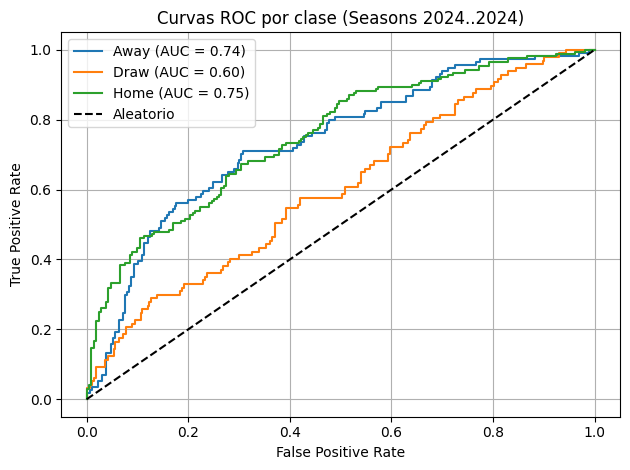


AUC macro: 0.697
AUC weighted: 0.709


In [20]:
# EJECUTAR EN LOCAL
plot_multiclass_roc(df, model, scaler, train_until_season=2023, test_until_season=2024, with_odds=True)

## **BENEFICIOS**

Por último, pero no por ello menos importante vamos a estudiar la última métrica: El **ROI (Return on Investment)**.

$$
ROI = \frac{\text{Beneficio}}{\text{Inversión}}
$$

Con el código siguiente lo que estoy haciendo es simular una apuesta de un euro al resultado que predice mi modelo, en todos los partidos que hay en test. Si se acierta sumamos la cuota que ofrece Bet365 pero si falla se resta la unidad apostada. Con esto calculamos el beneficio neto y el ROI.

In [30]:
# ============================================
# ROI por temporada (sin df_old) - Celda única
# ============================================

# --- Rutas (fallback si no existen variables del proyecto) ---
try:
    ROOT
except NameError:
    ROOT = Path(".")
try:
    DATA
except NameError:
    DATA = ROOT / "data"

FEAT = DATA / "03_features"

# --- Carga base: df_final ya incluye nombres de equipos ---
df = pd.read_parquet(FEAT / "df_final.parquet").reset_index(drop=True)

# --- Constantes útiles ---
CLASS2TXT = {0: "A", 1: "D", 2: "H"}   # 0=Away, 1=Draw, 2=Home
TXT2IDX   = {'A':0, 'D':1, 'H':2}

# ---------- Split de TEST con índices ----------
def _prep_test_split(
    df: pd.DataFrame,
    train_until_season: int,
    with_odds: bool,
    test_until_season: int | None = None
):
    # Importante: excluir variables de nombre de equipos de X
    drop_common = [
        'FTR','target','Date','has_xg_data',
        'a_squad_size_prev_season','away_form_gd_6','home_form_gd_6',
        'HomeTeam_norm','AwayTeam_norm','row_id'  # <- evita fuga de info
    ]
    drop_mode = (['overround','pimp2','B365D'] if with_odds else
                 ['fase_temporada_inicio','fase_temporada_mitad',
                  'B365H','B365D','B365A','overround','pimp1','pimpx','pimp2'])
    drop_cols = list(dict.fromkeys(drop_common + drop_mode))

    y_all = df['target']
    X_all = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    valid = y_all.notna()
    if with_odds:
        for c in ['B365H','B365A']:
            if c in X_all.columns:
                valid &= X_all[c].notna()
    valid &= X_all.notna().all(axis=1)

    X_all = X_all.loc[valid].copy()
    y_all = y_all.loc[valid].astype(int)

    if 'Season' not in X_all.columns:
        raise ValueError("Falta 'Season' para el split temporal.")

    test_mask = X_all['Season'] > train_until_season
    if test_until_season is not None:
        test_mask &= (X_all['Season'] <= test_until_season)

    idx_test = X_all.index[test_mask]
    X_test = X_all.loc[idx_test].drop(columns=['Season'])
    y_test = y_all.loc[idx_test]
    return X_test, y_test, idx_test

# ---------- Alinear columnas al fit ----------
def _align_to_fit_columns(X: pd.DataFrame, fitter, feature_names: list[str] | None = None) -> pd.DataFrame:
    cols_fit = feature_names if feature_names is not None else getattr(fitter, "feature_names_in_", None)
    if cols_fit is None:
        return X
    cols_fit = list(cols_fit)
    missing = [c for c in cols_fit if c not in X.columns]
    extra   = [c for c in X.columns   if c not in cols_fit]
    if extra:
        X = X.drop(columns=extra)
    if missing:
        raise ValueError(
            "X_test no contiene columnas usadas al entrenar:\n"
            f"- Faltan: {missing}\n"
            "Usa el mismo esquema (with_odds/drop_cols) que en el fit, "
            "o pasa 'feature_names' con la lista exacta del entrenamiento."
        )
    return X[cols_fit]

# ---------- Meta alineada (nombres + cuotas) desde df ----------
def attach_names_and_odds(df: pd.DataFrame, idx: pd.Index) -> pd.DataFrame:
    need = ["Season","Date","HomeTeam_norm","AwayTeam_norm","B365H","B365D","B365A"]
    missing = [c for c in need if c not in df.columns]
    if missing:
        raise ValueError(f"Faltan columnas en df: {missing}")
    meta = df.loc[idx, need].copy()
    meta["Date"] = pd.to_datetime(meta["Date"], errors="coerce")
    return meta

# ---------- Utilidades de reporting ----------
def _max_drawdown(equity: pd.Series):
    """Devuelve drawdown máximo: (mdd_abs, mdd_pct, peak_idx, trough_idx)."""
    if equity.empty:
        return 0.0, 0.0, None, None
    running_max = equity.cummax()
    drawdown = running_max - equity
    trough_idx = drawdown.idxmax()
    peak_idx = equity.loc[:trough_idx].idxmax() if trough_idx is not None else None
    mdd_abs = float(drawdown.max())
    peak_val = float(equity.loc[peak_idx]) if peak_idx is not None else 1.0
    mdd_pct = float(mdd_abs / peak_val) if peak_val > 0 else 0.0
    return mdd_abs, mdd_pct, peak_idx, trough_idx

def _edge_bins(edge: pd.Series, bins=(-np.inf, 0.0, 0.02, 0.05, np.inf),
               labels=("<0%", "0–2%", "2–5%", "≥5%")):
    """Discretiza edge (EV de la PREDICCIÓN) en tramos para analizar ROI."""
    return pd.cut(edge, bins=bins, labels=labels, include_lowest=True, right=False)

# ---------- Simulación ROI (con columnas de "valor" EV por clase) ----------
def simulate_bet365_roi(
    df: pd.DataFrame,
    model,
    scaler,
    train_until_season: int,
    test_until_season: int | None = None,
    with_odds: bool = True,
    stake: float = 1.0,
    feature_names: list[str] | None = None,
    min_edge: float = 0.00,     # filtro por EV mínimo de la PREDICCIÓN
):
    # 1) TEST
    X_test, y_test, idx_test = _prep_test_split(
        df, train_until_season=train_until_season,
        with_odds=with_odds, test_until_season=test_until_season
    )
    if len(X_test) == 0:
        return None, np.nan, np.nan

    # 2) Alinear columnas y predecir
    X_test = _align_to_fit_columns(X_test, scaler, feature_names=feature_names)
    Xs     = scaler.transform(X_test)
    proba  = model.predict_proba(Xs)
    y_pred = model.predict(Xs)

    # 3) Meta (nombres/fechas/cuotas) desde df
    res = attach_names_and_odds(df, idx_test)
    res['true_result']      = y_test.loc[res.index].values
    res['predicted_result'] = pd.Series(y_pred, index=idx_test).loc[res.index].values

    # 4) Probs/odds/edge de la predicción y "value" EV por clase
    name_map  = {0:'A',1:'D',2:'H'}
    classes   = list(model.classes_)  # típicamente [0,1,2]
    proba_df  = pd.DataFrame(proba, index=idx_test, columns=[name_map.get(c, str(c)) for c in classes]).loc[res.index]
    proba_fix = proba_df.reindex(columns=['A','D','H'])
    odds_fix  = res[['B365A','B365D','B365H']].rename(columns={'B365A':'A','B365D':'D','B365H':'H'})[['A','D','H']]

    pred_txt = pd.Series(y_pred, index=idx_test).map(name_map).loc[res.index]
    pred_idx = pred_txt.map(TXT2IDX).to_numpy()

    P, O = proba_fix.to_numpy(), odds_fix.to_numpy()

    res['Pred']           = pred_txt
    res['predicted_prob'] = P[np.arange(len(res)), pred_idx]
    res['predicted_odds'] = O[np.arange(len(res)), pred_idx]
    res['edge']           = res['predicted_prob'] * res['predicted_odds'] - 1.0

    # Value betting (mejor EV entre H/D/A, informativo)
    EV = proba_fix * odds_fix - 1.0
    best_idx = EV.to_numpy().argmax(axis=1)
    labels = np.array(['A','D','H'])
    res['value_pick'] = labels[best_idx]
    res['value_ev']   = EV.to_numpy()[np.arange(len(EV)), best_idx]
    res['value_prob'] = P[np.arange(len(P)), best_idx]
    res['value_odds'] = O[np.arange(len(O)), best_idx]

    # 5) Filtros
    mask_odds = res[['B365H','B365D','B365A']].notna().all(axis=1)
    res = res.loc[mask_odds].copy()
    if min_edge > 0:
        res = res.loc[res['edge'] >= min_edge].copy()
    if res.empty:
        return None, np.nan, np.nan

    # 6) Simulación (apuesto SIEMPRE a la predicción)
    res['bet_outcome'] = np.where(
        res['predicted_result'] == res['true_result'],
        res['predicted_odds'] * stake, 0.0
    )
    res['net_profit'] = res['bet_outcome'] - stake

    # Fechas amigables
    res['Date'] = pd.to_datetime(res['Date'], errors='coerce').dt.strftime('%Y-%m-%d')

    total_net = float(res['net_profit'].sum())
    n_bets    = int(len(res))
    roi       = total_net / (stake * n_bets) if n_bets > 0 else np.nan
    return res, roi, total_net

# ---------- Rejilla ROI por temporada ----------
def build_roi_grid(
    df: pd.DataFrame,
    model, scaler,
    seasons: list[int] | None = None,
    with_odds: bool = True,
    stake: float = 1.0,
    feature_names: list[str] | None = None,
    min_edge: float = 0.00,
    model_name: str = "base",
    out_dir: Path | None = None
):
    seasons_all = sorted(df["Season"].dropna().astype(int).unique())
    if seasons is None:
        seasons = seasons_all

    OUT = (out_dir or (ROOT / "outputs"))
    OUT.mkdir(parents=True, exist_ok=True)

    rows = []
    flat_for_csv = []

    for test_season in seasons:
        train_until = test_season - 1
        if train_until < seasons_all[0]:
            continue

        res, roi, total_net = simulate_bet365_roi(
            df, model, scaler,
            train_until_season=train_until,
            test_until_season=test_season,
            with_odds=with_odds, stake=stake,
            feature_names=feature_names, min_edge=min_edge
        )
        if res is None or len(res) == 0:
            continue

        tmp = res.copy()
        tmp['_Date'] = pd.to_datetime(tmp['Date'], errors='coerce')
        tmp = tmp.sort_values('_Date').drop(columns=['_Date'])

        equity = tmp['net_profit'].cumsum()
        mdd_abs, mdd_pct, *_ = _max_drawdown(equity)

        hit_rate = float((tmp['predicted_result'] == tmp['true_result']).mean())
        avg_odds = float(tmp['predicted_odds'].mean())
        avg_edge = float(tmp['edge'].mean())
        avg_value_ev = float(tmp['value_ev'].mean())

        by_class = tmp.groupby(tmp['predicted_result']).agg(
            profit=('net_profit','sum'), n=('net_profit','size')
        )
        profit_by_class = {CLASS2TXT.get(int(k), str(k)): float(v) for k, v in by_class['profit'].items()}

        bins = _edge_bins(tmp['edge'])
        by_bin = tmp.groupby(bins, observed=True).agg(
            n=('net_profit','size'),
            profit=('net_profit','sum'),
            avg_prob=('predicted_prob','mean'),
            avg_odds=('predicted_odds','mean'),
            avg_edge=('edge','mean')
        ).reset_index(names='edge_bin')
        by_bin['roi'] = by_bin.apply(lambda r: (r['profit']/(stake*r['n'])) if r['n']>0 else np.nan, axis=1)
        roi_by_edge_bins = [
            {
                "bin": str(row['edge_bin']),
                "n": int(row['n']),
                "roi": float(row['roi']),
                "profit_total": float(row['profit']),
                "avg_prob": float(row['avg_prob']),
                "avg_odds": float(row['avg_odds']),
                "avg_edge": float(row['avg_edge']),
            }
            for _, row in by_bin.iterrows()
        ]

        rows.append({
            "model": model_name,
            "train_until": int(train_until),
            "test_season": int(test_season),
            "n_bets": int(len(tmp)),
            "profit_total": float(total_net),
            "roi": float(roi),
            "hit_rate": float(hit_rate),
            "avg_odds": float(avg_odds),
            "avg_edge": float(avg_edge),
            "avg_value_ev": float(avg_value_ev),
            "profit_by_class": profit_by_class,
            "equity": [float(x) for x in equity.tolist()],
            "max_drawdown_abs": float(mdd_abs),
            "max_drawdown_pct": float(mdd_pct),
            "roi_by_edge_bins": roi_by_edge_bins,
            "stake": float(stake),
            "min_edge": float(min_edge),
        })

        flat_for_csv.append({
            "model": model_name,
            "test_season": int(test_season),
            "train_until": int(train_until),
            "n_bets": int(len(tmp)),
            "roi": float(roi),
            "profit_total": float(total_net),
            "hit_rate": float(hit_rate),
            "avg_odds": float(avg_odds),
            "avg_edge": float(avg_edge),
            "avg_value_ev": float(avg_value_ev),
            "max_drawdown_pct": float(mdd_pct),
            "stake": float(stake),
            "min_edge": float(min_edge),
        })

    tag = f"{model_name}".replace(" ", "_")
    (OUT / f"roi_by_season_{tag}.json").write_text(json.dumps(rows, ensure_ascii=False, indent=2), encoding="utf-8")
    if flat_for_csv:
        pd.DataFrame(flat_for_csv).sort_values("test_season").to_csv(OUT / f"roi_by_season_{tag}.csv", index=False)

    print(f"Guardados:\n- {OUT/f'roi_by_season_{tag}.json'}\n- {OUT/f'roi_by_season_{tag}.csv'}")
    return rows

# =========================
# EJEMPLOS DE USO (comenta/ajusta)
# =========================
# Asume que ya has entrenado:
#   - model, scaler  (baseline)
#   - model_sm, scaler_sm (SMOTE) si quieres
#
# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import StandardScaler
# ... (tu entrenamiento aquí, asegurando NO usar HomeTeam_norm/AwayTeam_norm en X)

# Ejemplo (descomenta cuando tengas model/scaler):
_ = build_roi_grid(
    df=df, model=model, scaler=scaler,
    seasons=None, with_odds=True, stake=1.0,
    min_edge=0.00, model_name="base"
)
_ = build_roi_grid(
    df=df, model=model_sm, scaler=scaler_sm,
    seasons=None, with_odds=True, stake=1.0,
    min_edge=0.00, model_name="smote"
)

Guardados:
- outputs/roi_by_season_base.json
- outputs/roi_by_season_base.csv
Guardados:
- outputs/roi_by_season_smote.json
- outputs/roi_by_season_smote.csv


In [36]:
# EJECUTAR EN LOCAL
results_df, roi, total_profit = simulate_bet365_roi(df, model, scaler, train_until_season=2024, test_until_season=2025, with_odds=True, stake=1.0)
print(roi)
print(total_profit)
results_df.tail(10)

-0.24
-9.84


,Season,Date,HomeTeam_norm,AwayTeam_norm,B365H,B365D,B365A,true_result,predicted_result,Pred,predicted_prob,predicted_odds,edge,value_pick,value_ev,value_prob,value_odds,bet_outcome,net_profit
7251,2025,2025-09-12,sevilla,elche,1.85,3.40,4.50,1,2,H,0.541928,1.85,0.002567,H,0.002567,0.541928,1.85,0.00,-1.00
7252,2025,2025-09-13,getafe,oviedo,1.95,3.10,4.50,2,2,H,0.409182,1.95,-0.202095,A,0.201801,0.267067,4.50,1.95,0.95
7253,2025,2025-09-13,sociedad,real madrid,5.00,4.33,1.60,0,0,A,0.554822,1.60,-0.112285,D,0.222138,0.282249,4.33,1.60,0.60
7254,2025,2025-09-13,ath bilbao,alaves,1.60,3.90,5.75,0,2,H,0.550616,1.60,-0.119014,D,0.206930,0.309469,3.90,0.00,-1.00
7255,2025,2025-09-13,ath madrid,villarreal,1.80,3.70,4.33,2,2,H,0.469999,1.80,-0.154001,D,0.264452,0.341744,3.70,1.80,0.80
7256,2025,2025-09-14,celta,girona,1.73,3.90,4.75,1,2,H,0.561560,1.73,-0.028502,D,0.087143,0.278755,3.90,0.00,-1.00
7257,2025,2025-09-14,levante,betis,3.25,3.25,2.30,1,0,A,0.364248,2.30,-0.162229,D,0.069974,0.329223,3.25,0.00,-1.00
7258,2025,2025-09-14,osasuna,vallecano,2.55,3.20,2.90,2,2,H,0.352265,2.55,-0.101724,D,0.111297,0.347280,3.20,2.55,1.55
7259,2025,2025-09-14,barcelona,valencia,1.22,7.00,11.00,2,2,H,0.830355,1.22,0.013033,H,0.013033,0.830355,1.22,1.22,0.22
7260,2025,2025-09-15,espanol,mallorca,2.10,3.40,3.50,2,1,D,0.368309,3.40,0.252250,D,0.252250,0.368309,3.40,0.00,-1.00


In [37]:
# =========================
# MATCH-LOG por temporada (predicción vs valor) + export
# =========================

# --- Mapas y utilidades ---
CLASS2TXT = {0:"A", 1:"D", 2:"H"}   # 0=Away,1=Draw,2=Home
TXT2CLASS = {"A":0, "D":1, "H":2}

def _edge_bins(edge: pd.Series,
               bins=(-np.inf, 0.0, 0.02, 0.05, np.inf),
               labels=("<0%", "0–2%", "2–5%", "≥5%")):
    """Tramos discretos para facilitar filtros por 'valor esperado' en la app."""
    return pd.cut(edge, bins=bins, labels=labels, include_lowest=True, right=False)

def _ensure_probs_adh(y_proba: np.ndarray, classes_model: np.ndarray) -> pd.DataFrame:
    """
    Devuelve DataFrame de probabilidades con columnas A/D/H,
    completando columnas ausentes con NaN si el modelo no las tuvo en train.
    """
    name_map = {0:"A", 1:"D", 2:"H"}
    cols = [name_map.get(int(c), str(c)) for c in classes_model]
    proba_df = pd.DataFrame(y_proba, columns=cols)
    for c in ["A","D","H"]:
        if c not in proba_df.columns:
            proba_df[c] = np.nan
    return proba_df[["A","D","H"]]

def _make_matchlog_from_eval(
    df: pd.DataFrame,
    y_test: pd.Series,
    y_pred: np.ndarray,
    y_proba: np.ndarray,
    idx_test: pd.Index,
    *,
    stake: float = 1.0,
    min_edge_pred: float = 0.00,
    min_edge_value: float | None = None
) -> pd.DataFrame:
    """
    Construye el match-log (una fila por partido del TEST de esa temporada).
    Incluye columnas para comparar estrategia de 'Predicción' vs 'Valor'.
    """
    # 1) Meta-información del propio df (alineación por índice)
    need = ["Date","Season","HomeTeam_norm","AwayTeam_norm","B365H","B365D","B365A"]
    missing = [c for c in need if c not in df.columns]
    if missing:
        raise ValueError(f"df necesita columnas {missing} para construir el match-log.")
    meta = df.loc[idx_test, need].copy()

    # 2) Probabilidades A/D/H y odds en mismo orden (A,D,H)
    proba_df = _ensure_probs_adh(y_proba, classes_model=np.array([0,1,2][:y_proba.shape[1]]))
    proba_df.index = idx_test
    odds_df = meta[["B365A","B365D","B365H"]].rename(columns={"B365A":"A","B365D":"D","B365H":"H"})

    # 3) Predicción del modelo + EV de la predicción
    pred_txt = pd.Series(y_pred, index=idx_test).map(CLASS2TXT)
    idx_of = {"A":0,"D":1,"H":2}
    pred_idx = pred_txt.map(idx_of).to_numpy()

    P = proba_df.to_numpy()
    O = odds_df[["A","D","H"]].to_numpy()

    out = meta.copy()
    out["true_result"]      = pd.Series(y_test, index=idx_test).values
    out["predicted_result"] = pd.Series(y_pred, index=idx_test).values
    out["Pred"]             = pred_txt.values

    out["predicted_prob"] = P[np.arange(len(out)), pred_idx]
    out["predicted_odds"] = O[np.arange(len(out)), pred_idx]
    out["edge"] = out["predicted_prob"] * out["predicted_odds"] - 1.0      # EV de la PREDICCIÓN

    # 4) Estrategia de VALOR: máxima EV entre H/D/A (sin mirar la predicción)
    ev_df = proba_df * odds_df - 1.0                                      # EV por clase
    best_idx = ev_df[["A","D","H"]].to_numpy().argmax(axis=1)
    labels  = np.array(["A","D","H"])
    out["value_pick"] = labels[best_idx]
    out["value_ev"]   = ev_df.to_numpy()[np.arange(len(out)), best_idx]
    out["value_prob"] = P[np.arange(len(out)), best_idx]
    out["value_odds"] = O[np.arange(len(out)), best_idx]

    # 5) Requiere cuotas completas y filtros de edge
    mask_ok_odds = out[["B365H","B365D","B365A"]].notna().all(axis=1)
    out = out.loc[mask_ok_odds].copy()
    if min_edge_pred > 0:
        out = out.loc[out["edge"] >= min_edge_pred].copy()
    if out.empty:
        return out

    if min_edge_value is None:
        min_edge_value = min_edge_pred
    # Nota: para comparar estrategias, NO filtramos por value_ev por defecto (se puede activar):
    if min_edge_value and (min_edge_value > 0):
        out["use_value"] = out["value_ev"] >= min_edge_value
    else:
        out["use_value"] = True

    # 6) Beneficios de cada estrategia (stake fijo)
    out["bet_return"] = np.where(
        out["predicted_result"] == out["true_result"], out["predicted_odds"] * stake, 0.0
    )
    out["net_profit"] = out["bet_return"] - stake

    value_idx = out["value_pick"].map(idx_of).to_numpy()
    value_hit = (value_idx == out["true_result"])
    value_ret = np.where(value_hit, out["value_odds"] * stake, 0.0)
    out["value_bet_return"] = np.where(out["use_value"], value_ret, 0.0)
    out["value_net_profit"] = np.where(out["use_value"], out["value_bet_return"] - stake, 0.0)

    # 7) Columnas de apoyo para filtros en la app
    out["Correct"]       = np.where(out["predicted_result"] == out["true_result"], "✓", "✗")
    out["value_correct"] = np.where(value_hit, "✓", "✗")
    out["edge_bin"]      = _edge_bins(out["edge"])
    out["value_bin"]     = _edge_bins(out["value_ev"])

    # 8) Orden temporal + formato fecha amigable
    out["Date"] = pd.to_datetime(out["Date"], errors="coerce")
    out = out.sort_values(["Date", out.index.name or "Season"]).reset_index(drop=True)
    out["Date"] = out["Date"].dt.strftime("%Y-%m-%d")

    return out


def build_matchlog_grid(
    df: pd.DataFrame,
    out_dir: Path,
    *,
    model: str = "base",          # "base" | "smote"
    with_odds: bool = True,
    random_state: int = 42,
    stake: float = 1.0,
    min_edge_pred: float = 0.00,
    min_edge_value: float | None = None
):
    """
    Para cada temporada S (train ≤ S-1, test = S) entrena/evalúa el modelo escogido,
    construye el match-log (partido a partido) con columnas de Predicción y Valor,
    y exporta CSV/JSON por temporada + un resumen por temporada con ROI de ambas estrategias.
    """
    out_dir.mkdir(parents=True, exist_ok=True)
    per_season_dir = out_dir / f"matchlogs_{model}"
    per_season_dir.mkdir(parents=True, exist_ok=True)

    seasons_all = sorted(df["Season"].dropna().astype(int).unique())
    season_summary = []

    for test_season in seasons_all:
        train_until = test_season - 1
        if train_until < seasons_all[0]:
            continue

        try:
            if model == "base":
                mdl, _, (mtr_tr, mtr_te), y_test, y_pred, y_proba, idx_test = run_logreg_eval_no_smote(
                    df, train_until_season=train_until, test_until_season=test_season,
                    with_odds=with_odds, random_state=random_state
                )
            else:
                mdl, _, (mtr_tr, mtr_te), y_test, y_pred, y_proba, idx_test = run_logreg_eval(
                    df, train_until_season=train_until, test_until_season=test_season,
                    with_odds=with_odds, random_state=random_state
                )

            # Si no hay test válido, sigue
            if (mtr_te is None) or (y_test is None) or (y_pred is None) or (y_proba is None) or (len(y_test) == 0):
                continue

            # Construye match-log para esa temporada
            ml = _make_matchlog_from_eval(
                df, y_test, y_pred, y_proba, idx_test,
                stake=stake, min_edge_pred=min_edge_pred, min_edge_value=min_edge_value
            )
            if ml.empty:
                continue

            # ROI/beneficio de cada estrategia en esa temporada
            n_pred = len(ml)                        # pred: una apuesta por fila tras filtro
            roi_pred = float(ml["net_profit"].sum() / (stake * n_pred))
            n_val = int(ml["use_value"].sum())      # valor: si filtras por value_ev, puede ser menor
            roi_val = float(ml.loc[ml["use_value"], "value_net_profit"].sum() / (stake * n_val)) if n_val > 0 else np.nan

            # Guardados por temporada
            csv_path  = per_season_dir / f"matchlog_{test_season}.csv"
            json_path = per_season_dir / f"matchlog_{test_season}.json"
            ml.to_csv(csv_path, index=False)
            ml.to_json(json_path, orient="records", force_ascii=False, indent=2)

            season_summary.append({
                "model": model,
                "train_until": int(train_until),
                "test_season": int(test_season),
                "n_pred_bets": int(n_pred),
                "roi_pred": roi_pred,
                "profit_pred": float(ml["net_profit"].sum()),
                "n_value_bets": int(n_val),
                "roi_value": roi_val,
                "profit_value": float(ml.loc[ml["use_value"], "value_net_profit"].sum() if n_val > 0 else 0.0),
                "min_edge_pred": float(min_edge_pred),
                "min_edge_value": float(min_edge_value if (min_edge_value is not None) else min_edge_pred),
                "n_test": int(mtr_te["n_test"]),
            })
            print(f"[{model}] Season {test_season}: guardado match-log ({len(ml)} filas)")

        except Exception as e:
            print(f"[MATCHLOG {model.upper()} SKIP] test={test_season} → {e}")

    # Resumen por temporada (tabla plana + index JSON para la app)
    if season_summary:
        df_sum = pd.DataFrame(season_summary).sort_values("test_season")
        df_sum.to_csv(out_dir / f"matchlog_season_summary_{model}.csv", index=False)
        (out_dir / f"matchlog_season_summary_{model}.json").write_text(
            json.dumps(season_summary, ensure_ascii=False, indent=2),
            encoding="utf-8"
        )
        print(f"Guardados:\n- {out_dir/f'matchlog_season_summary_{model}.csv'}\n- {out_dir/f'matchlog_season_summary_{model}.json'}")
    else:
        print("Sin temporadas válidas para exportar matchlogs.")

# =========================
# EJEMPLOS DE USO
# =========================
# Asumimos:
# - df = df_final (con HomeTeam_norm y AwayTeam_norm)
# - OUT = ROOT / "outputs"
OUT.mkdir(parents=True, exist_ok=True)

# BASE (sin SMOTE). Puedes ajustar min_edge_pred para exigir EV mínimo en la estrategia de predicción
build_matchlog_grid(
    df=df,
    out_dir=OUT,
    model="base",
    with_odds=True,
    random_state=42,
    stake=1.0,
    min_edge_pred=0.00,   # prueba 0.02 / 0.05 si quieres “apostar solo cuando hay valor en la predicción”
    min_edge_value=None   # None = no filtrar la estrategia de valor; pon 0.02/0.05 si quieres filtrarla también
)

# SMOTE (si ya tienes definidas run_logreg_eval y funciona análogo)
build_matchlog_grid(
    df=df,
    out_dir=OUT,
    model="smote",
    with_odds=True,
    random_state=42,
    stake=1.0,
    min_edge_pred=0.00,
    min_edge_value=None
)

Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.6105263157894737, 'log_loss': 0.8529715015512208, 'brier': 0.5126050979185605, 'n_train': 380}

=== Test (Seasons 2007..2007) ===
{'accuracy': 0.4131578947368421, 'log_loss': 1.2357788018071167, 'brier': 0.7108253532823114, 'n_test': 380, 'season_min': 2007, 'season_max': 2007}
[base] Season 2007: guardado match-log (380 filas)
Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5552631578947368, 'log_loss': 0.92320990288169, 'brier': 0.5525509324329174, 'n_train': 760}

=== Test (Seasons 2008..2008) ===
{'accuracy': 0.4789473684210526, 'log_loss': 1.0902924033829702, 'brier': 0.6481976863657879, 'n_test': 380, 'season_min': 2008, 'season_max': 2008}
[base] Season 2008: guardado match-log (380 filas)
Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5491228070175439, 'log_loss': 0.9354323737003613, 'brier': 0.5585766915416096, 'n_train': 1140}

=== Test (Seasons 20

## **COMPARACIÓN CON EL MODELO DE BET365**

El modelo basado en las cuotas de Bet365 consiste en predecir siempre el resultado más probable según la probabilidad implícita.

In [40]:
# =========================
# Bet365 Baseline + Export + Comparaciones
# =========================

# --- Split temporal (idéntico a tu flujo) ---
def _prep_test_split(
    df: pd.DataFrame,
    train_until_season: int,
    with_odds: bool,
    test_until_season: int | None = None
):
    drop_common = ['FTR','target','Date','has_xg_data',
                   'a_squad_size_prev_season','away_form_gd_6','home_form_gd_6']
    drop_mode = (['overround','pimp2','B365D'] if with_odds else
                 ['fase_temporada_inicio','fase_temporada_mitad',
                  'B365H','B365D','B365A','overround','pimp1','pimpx','pimp2'])
    drop_cols = list(dict.fromkeys(drop_common + drop_mode))

    y_all = df['target']
    X_all = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    valid = y_all.notna()
    if with_odds:
        for c in ['B365H','B365A']:
            if c in X_all.columns:
                valid &= X_all[c].notna()
    valid &= X_all.notna().all(axis=1)

    X_all = X_all.loc[valid].copy()
    y_all = y_all.loc[valid].astype(int)

    if 'Season' not in X_all.columns:
        raise ValueError("Falta 'Season' para el split temporal.")

    test_mask = X_all['Season'] > train_until_season
    if test_until_season is not None:
        test_mask &= (X_all['Season'] <= test_until_season)

    idx_test = X_all.index[test_mask]
    X_test = X_all.loc[idx_test].drop(columns=['Season'])
    y_test = y_all.loc[idx_test]
    return X_test, y_test, idx_test


# --- Evaluación Bet365 en un rango temporal ---
def evaluate_bet365_baseline(
    df: pd.DataFrame,
    train_until_season: int = 2023,
    test_until_season: int | None = None,
    with_odds: bool = True,
    round_decimals: int = 4,
    stake: float = 1.0,
):
    """
    Baseline Bet365:
      - TEST: (train_until, test_until]
      - Prob implícitas normalizadas
      - Métricas: accuracy, log_loss, brier
      - ROI apostando al favorito Bet365
      - Devuelve (tabla partido a partido, métricas)
    """
    # 1) TEST
    X_test, y_test, idx = _prep_test_split(
        df, train_until_season=train_until_season,
        with_odds=with_odds, test_until_season=test_until_season
    )
    if len(X_test) == 0:
        rng = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
        print(f"⚠️ No hay TEST disponible tras filtrar (Seasons {rng}).")
        return pd.DataFrame(), {}

    # 2) Cuotas desde df
    need_cols = ['B365H','B365D','B365A']
    missing = [c for c in need_cols if c not in df.columns]
    if missing:
        raise ValueError(f"df debe contener columnas de cuotas {missing}")

    odds_df = df.loc[idx, need_cols].copy()
    mask_ok = odds_df.notna().all(axis=1)
    for c in need_cols:
        mask_ok &= (pd.to_numeric(odds_df[c], errors='coerce') > 0)
    odds_df = odds_df.loc[mask_ok].astype(float)
    y_test  = y_test.loc[mask_ok]
    idx     = odds_df.index

    if odds_df.empty:
        print("⚠️ No hay partidos con cuotas B365 completas en el TEST.")
        return pd.DataFrame(), {}

    # 3) Prob implícitas normalizadas
    inv = 1.0 / odds_df[need_cols]
    overround = inv.sum(axis=1).replace(0, np.nan)
    prob_norm = inv.div(overround, axis=0)

    # 4) Proba en orden de clases (0=A,1=D,2=H) y pick
    bet365_proba = np.column_stack([
        prob_norm['B365A'].to_numpy(),
        prob_norm['B365D'].to_numpy(),
        prob_norm['B365H'].to_numpy()
    ])
    bet365_pred = bet365_proba.argmax(axis=1)

    # 5) Métricas
    classes = [0,1,2]
    acc = float(accuracy_score(y_test, bet365_pred))
    ll  = float(log_loss(y_test, bet365_proba, labels=classes))
    y_bin = label_binarize(y_test, classes=classes)
    brier = float(np.mean(np.sum((bet365_proba - y_bin)**2, axis=1)))

    # 6) Tabla partido a partido
    out = pd.DataFrame(index=idx)
    extra = {}
    for c in ['Date','Season','HomeTeam_norm','AwayTeam_norm']:
        extra[c] = df.loc[idx, c] if c in df.columns else pd.Series(index=idx, dtype='object')

    out['Date'] = pd.to_datetime(extra['Date'], errors='coerce').dt.strftime('%Y-%m-%d')
    if 'Season' in df.columns:
        out['Season'] = extra['Season'].astype('Int64')
    out['HomeTeam_norm'] = extra['HomeTeam_norm'].astype('string')
    out['AwayTeam_norm'] = extra['AwayTeam_norm'].astype('string')

    out['B365H'] = odds_df['B365H'].round(round_decimals)
    out['B365D'] = odds_df['B365D'].round(round_decimals)
    out['B365A'] = odds_df['B365A'].round(round_decimals)
    out['p_H']   = prob_norm['B365H'].round(round_decimals)
    out['p_D']   = prob_norm['B365D'].round(round_decimals)
    out['p_A']   = prob_norm['B365A'].round(round_decimals)
    out['true_result'] = y_test.values
    out['bet365_pred'] = bet365_pred

    # 7) ROI del favorito Bet365
    pick_idx = bet365_pred
    odds_mat = np.column_stack([odds_df['B365A'], odds_df['B365D'], odds_df['B365H']])
    picked_odds = odds_mat[np.arange(len(odds_mat)), pick_idx]
    out['picked_odds'] = picked_odds
    out['bet_return']  = np.where(out['bet365_pred'] == out['true_result'], out['picked_odds'] * stake, 0.0)
    out['net_profit']  = out['bet_return'] - stake
    out['Cum_net_profit'] = out['net_profit'].cumsum()

    # Edge informativo del pick
    pA = prob_norm['B365A'].to_numpy()
    pD = prob_norm['B365D'].to_numpy()
    pH = prob_norm['B365H'].to_numpy()
    p_mat = np.column_stack([pA,pD,pH])
    out['edge_b365_pick'] = (p_mat[np.arange(len(p_mat)), pick_idx] * picked_odds) - 1.0

    n_eval = int(len(out))
    total_profit = float(out['net_profit'].sum())
    investment_total = float(stake * n_eval)
    roi = float(total_profit / investment_total) if investment_total > 0 else np.nan

    metrics = {
        "accuracy": acc,
        "log_loss": ll,
        "brier": brier,
        "n_test_with_odds": n_eval,
        "roi": roi,
        "profit_total": total_profit,
        "investment_total": investment_total,   # << añadido
        "stake": float(stake)
    }

    rng = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
    print("Baseline Bet365 — Prob. implícitas normalizadas")
    print(f"Rango TEST: Seasons {rng} | n={n_eval} | ROI: {roi*100:.2f}% | Profit: {total_profit:.2f}")

    return out.reset_index(drop=True), metrics


# --- Grid por temporada + export ---
def build_bet365_grid(
    df: pd.DataFrame,
    out_dir: Path,
    seasons: list[int] | None = None,
    with_odds: bool = True,
    stake: float = 1.0,
    round_decimals: int = 4,
    save_matchlogs: bool = True
):
    """
    Para cada temporada S (train ≤ S-1, test = S):
      - matchlog Bet365 (opcional CSV/JSON)
      - resumen por temporada (JSON+CSV) con ROI y investment_total
    """
    out_dir.mkdir(parents=True, exist_ok=True)
    per_season_dir = out_dir / "bet365_matchlogs"
    if save_matchlogs:
        per_season_dir.mkdir(parents=True, exist_ok=True)

    seasons_all = sorted(df["Season"].dropna().astype(int).unique())
    if seasons is None:
        seasons = seasons_all

    rows_json, rows_flat = [], []

    for test_season in seasons:
        train_until = test_season - 1
        if train_until < seasons_all[0]:  # sin historial
            continue

        try:
            tbl, met = evaluate_bet365_baseline(
                df,
                train_until_season=train_until,
                test_until_season=test_season,
                with_odds=with_odds,
                round_decimals=round_decimals,
                stake=stake
            )
            if tbl.empty:
                continue

            if save_matchlogs:
                (per_season_dir / f"matchlog_{test_season}.csv").write_text(
                    tbl.to_csv(index=False), encoding="utf-8"
                )
                (per_season_dir / f"matchlog_{test_season}.json").write_text(
                    tbl.to_json(orient="records", force_ascii=False, indent=2),
                    encoding="utf-8"
                )

            rows_json.append({
                "train_until": int(train_until),
                "test_season": int(test_season),
                "metrics": {
                    "accuracy": float(met["accuracy"]),
                    "log_loss": float(met["log_loss"]),
                    "brier":    float(met["brier"]),
                    "roi":      float(met["roi"]),
                    "profit_total": float(met["profit_total"]),
                    "investment_total": float(met["investment_total"]),  # << añadido
                    "n_test":   int(met["n_test_with_odds"]),
                    "stake":    float(met["stake"])
                }
            })
            rows_flat.append({
                "test_season": int(test_season),
                "train_until": int(train_until),
                "acc": float(met["accuracy"]),
                "logloss": float(met["log_loss"]),
                "brier": float(met["brier"]),
                "roi": float(met["roi"]),
                "profit_total": float(met["profit_total"]),
                "investment_total": float(met["investment_total"]),      # << añadido
                "n_test": int(met["n_test_with_odds"]),
            })

            print(f"[Bet365] Season {test_season}: OK ({len(tbl)} partidos)")

        except Exception as e:
            print(f"[BET365 SKIP] test={test_season} → {e}")

    (out_dir / "bet365_grid.json").write_text(json.dumps(rows_json, ensure_ascii=False, indent=2), encoding="utf-8")
    pd.DataFrame(rows_flat).sort_values("test_season").to_csv(out_dir / "bet365_metrics_by_season.csv", index=False)

    print("Guardados:")
    print(f"- {out_dir/'bet365_grid.json'}")
    print(f"- {out_dir/'bet365_metrics_by_season.csv'}")
    if save_matchlogs:
        print(f"- {out_dir/'bet365_matchlogs'}/matchlog_<SEASON>.csv/json")


# --- Comparación modelo vs Bet365 por temporada ---
def build_season_comparison_model_vs_bet365(
    out_dir: Path,
    model_tag: str = "base"  # coincide con el nombre usado en roi_by_season_<tag>.csv
):
    """
    Une outputs/roi_by_season_<model_tag>.csv (tu modelo) con
    outputs/bet365_metrics_by_season.csv y calcula deltas.
    """
    df_m = pd.read_csv(out_dir / f"roi_by_season_{model_tag}.csv")
    df_b = pd.read_csv(out_dir / "bet365_metrics_by_season.csv")

    # Normaliza nombres por si difieren
    df_m = df_m.rename(columns={"profit_total":"profit_model", "roi":"roi_model", "n_bets":"n_bets_model"})
    df_b = df_b.rename(columns={"profit_total":"profit_bet365", "roi":"roi_bet365", "n_test":"n_bets_bet365"})

    if "stake" not in df_m.columns:
        df_m["stake"] = 1.0  # fallback si faltara
    if "stake" not in df_b.columns:
        df_b["stake"] = 1.0

    df_m["investment_total_model"] = df_m["stake"] * df_m["n_bets_model"]
    df_b["investment_total_bet365"] = df_b["stake"] * df_b["n_bets_bet365"]

    comp = pd.merge(df_m, df_b, on=["test_season","train_until"], how="inner", suffixes=("_m","_b"))
    comp["delta_roi"]    = comp["roi_model"]    - comp["roi_bet365"]
    comp["delta_profit"] = comp["profit_model"] - comp["profit_bet365"]

    comp_sorted = comp.sort_values("test_season")
    comp_sorted.to_csv(out_dir / f"comparison_season_{model_tag}_vs_bet365.csv", index=False)
    (out_dir / f"comparison_season_{model_tag}_vs_bet365.json").write_text(
        comp_sorted.to_json(orient="records", force_ascii=False, indent=2),
        encoding="utf-8"
    )
    print(f"Guardados comparativos temporada:\n- {out_dir/f'comparison_season_{model_tag}_vs_bet365.csv'}\n- {out_dir/f'comparison_season_{model_tag}_vs_bet365.json'}")


# --- Comparación por partido (una temporada) modelo vs Bet365 ---
def build_match_comparison_for_season(
    out_dir: Path,
    season: int,
    model_tag: str = "base"
):
    """
    Une matchlogs:
      - outputs/matchlogs_<model_tag>/matchlog_<season>.csv
      - outputs/bet365_matchlogs/matchlog_<season>.csv
    por (Date, HomeTeam_norm, AwayTeam_norm) y calcula deltas por partido.
    """
    ml_model = pd.read_csv(out_dir / f"matchlogs_{model_tag}" / f"matchlog_{season}.csv")
    ml_b365  = pd.read_csv(out_dir / "bet365_matchlogs" / f"matchlog_{season}.csv")

    key = ["Date","HomeTeam_norm","AwayTeam_norm"]
    both = pd.merge(ml_model, ml_b365, on=key, how="inner", suffixes=("_model","_b365"))

    # Columnas mínimas de interés
    keep = key + [
        "Season_model","true_result_model","predicted_result","Pred","edge",
        "predicted_odds","net_profit","Cum_net_profit",
        "bet365_pred","picked_odds","net_profit_b365","Cum_net_profit_b365"
    ]
    # Renombra si no existen exactamente
    if "net_profit_model" in both.columns:
        both["net_profit"] = both["net_profit_model"]
    if "Cum_net_profit_model" in both.columns:
        both["Cum_net_profit"] = both["Cum_net_profit_model"]
    if "net_profit_b365" not in both.columns and "net_profit_b365" not in keep:
        if "net_profit_b365" in both.columns:
            pass

    # Deltas por partido
    both["delta_profit"] = both["net_profit"] - both["net_profit_b365"]

    # Orden temporal
    both["Date"] = pd.to_datetime(both["Date"], errors="coerce")
    both = both.sort_values(["Date"]).reset_index(drop=True)
    both["Date"] = both["Date"].dt.strftime("%Y-%m-%d")

    out_csv  = out_dir / f"comparison_matchlog_{season}_{model_tag}_vs_bet365.csv"
    out_json = out_dir / f"comparison_matchlog_{season}_{model_tag}_vs_bet365.json"
    both.to_csv(out_csv, index=False)
    both.to_json(out_json, orient="records", force_ascii=False, indent=2)
    print(f"Guardados comparativos por partido ({season}):\n- {out_csv}\n- {out_json}")


# =========================
# EJEMPLOS DE USO
# =========================
# OUT = ROOT / "outputs"
# OUT.mkdir(parents=True, exist_ok=True)

# 1) Generar baseline Bet365 por temporada (incluye investment_total y matchlogs)
build_bet365_grid(df, out_dir=OUT, seasons=None, with_odds=True, stake=1.0, save_matchlogs=True)

# 2) Comparar tu modelo vs Bet365 por temporada (usa tu CSV: roi_by_season_base.csv)
build_season_comparison_model_vs_bet365(OUT, model_tag="base")

# 3) Comparar por partido en una temporada concreta (usa tus matchlogs y los de Bet365)
build_match_comparison_for_season(OUT, season=2025, model_tag="base")

Baseline Bet365 — Prob. implícitas normalizadas
Rango TEST: Seasons 2007..2007 | n=380 | ROI: -3.47% | Profit: -13.19
[Bet365] Season 2007: OK (380 partidos)
Baseline Bet365 — Prob. implícitas normalizadas
Rango TEST: Seasons 2008..2008 | n=380 | ROI: 7.91% | Profit: 30.05
[Bet365] Season 2008: OK (380 partidos)
Baseline Bet365 — Prob. implícitas normalizadas
Rango TEST: Seasons 2009..2009 | n=380 | ROI: 4.28% | Profit: 16.28
[Bet365] Season 2009: OK (380 partidos)
Baseline Bet365 — Prob. implícitas normalizadas
Rango TEST: Seasons 2010..2010 | n=380 | ROI: 9.04% | Profit: 34.36
[Bet365] Season 2010: OK (380 partidos)
Baseline Bet365 — Prob. implícitas normalizadas
Rango TEST: Seasons 2011..2011 | n=380 | ROI: -7.91% | Profit: -30.06
[Bet365] Season 2011: OK (380 partidos)
Baseline Bet365 — Prob. implícitas normalizadas
Rango TEST: Seasons 2012..2012 | n=380 | ROI: -3.74% | Profit: -14.20
[Bet365] Season 2012: OK (380 partidos)
Baseline Bet365 — Prob. implícitas normalizadas
Rango TEST

In [46]:
tabla_bet365, met_bet365 = evaluate_bet365_baseline(df, train_until_season=2024, test_until_season=2025, with_odds=True)

Baseline Bet365 — Prob. implícitas normalizadas
Rango TEST: Seasons 2025..2025 | n=41 | ROI: -3.39% | Profit: -1.39


In [47]:
# ============================================
# Datos para GRAFICAR en la web: Modelo vs Bet365 (curvas acumuladas)
# Compatible con _prep_test_split que devuelve 2 o 3 valores
# ============================================
import json
from pathlib import Path
import numpy as np
import pandas as pd

CLASS2LABEL = {0: "Away", 1: "Draw", 2: "Home"}

def _ensure_probs_adh(y_proba: np.ndarray, classes_model) -> pd.DataFrame:
    name_map = {0:"A", 1:"D", 2:"H"}
    cols = [name_map.get(int(c), str(c)) for c in classes_model]
    proba_df = pd.DataFrame(y_proba, columns=cols)
    for c in ["A","D","H"]:
        if c not in proba_df.columns:
            proba_df[c] = np.nan
    return proba_df[["A","D","H"]]

def _prep_test_split_flex(df, train_until_season, with_odds, test_until_season):
    """Envuelve tu _prep_test_split y devuelve siempre (X_test, y_test, idx_test)."""
    out = _prep_test_split(
        df, train_until_season=train_until_season,
        with_odds=with_odds, test_until_season=test_until_season
    )
    if not isinstance(out, tuple):
        raise ValueError("Respuesta inesperada de _prep_test_split.")
    if len(out) == 3:
        X_test, y_test, idx_test = out
    elif len(out) == 2:
        X_test, y_test = out
        idx_test = X_test.index
    else:
        raise ValueError("Respuesta inesperada de _prep_test_split (ni 2 ni 3 elementos).")
    return X_test, y_test, idx_test

def build_cumprofit_series_one_season(
    df: pd.DataFrame,
    model, scaler,
    *, train_until_season: int,
    test_until_season: int | None = None,
    with_odds: bool = True,
    stake: float = 1.0,
    round_decimals: int = 3
) -> tuple[pd.DataFrame, dict]:

    # 1) TEST (flex)
    X_test, y_test, idx = _prep_test_split_flex(
        df, train_until_season=train_until_season,
        with_odds=with_odds, test_until_season=test_until_season
    )
    if len(X_test) == 0:
        return pd.DataFrame(), {}

    # 2) Alinear + predecir modelo
    X_test = _align_to_fit_columns(X_test, scaler)
    Xs   = scaler.transform(X_test)
    yhat = model.predict(Xs)
    proba = model.predict_proba(Xs)
    classes_used = getattr(model, "classes_", np.array([0,1,2]))

    # 3) Meta y cuotas
    need = ["Date","Season","HomeTeam_norm","AwayTeam_norm","B365H","B365D","B365A"]
    miss = [c for c in need if c not in df.columns]
    if miss:
        raise ValueError(f"df necesita columnas {miss}")
    meta = df.loc[idx, need].copy()

    mask_ok = meta[["B365H","B365D","B365A"]].notna().all(axis=1)
    for c in ["B365H","B365D","B365A"]:
        mask_ok &= (pd.to_numeric(meta[c], errors="coerce") > 0)
    if not mask_ok.any():
        return pd.DataFrame(), {}

    meta   = meta.loc[mask_ok].copy()
    y_test = y_test.loc[mask_ok]
    # re-alinear pred y proba a las filas válidas
    yhat   = pd.Series(yhat, index=idx).loc[mask_ok].to_numpy()
    proba  = proba[mask_ok.values, :]

    # 4) Prob implícitas Bet365 normalizadas y predicción Bet365
    odds = meta[["B365H","B365D","B365A"]].astype(float)
    inv  = 1.0 / odds
    over = inv.sum(axis=1).replace(0, np.nan)
    pnorm = inv.div(over, axis=0)
    bet365_proba_mat = np.column_stack([
        pnorm["B365A"].to_numpy(),  # Away -> 0
        pnorm["B365D"].to_numpy(),  # Draw -> 1
        pnorm["B365H"].to_numpy(),  # Home -> 2
    ])
    bet365_pred = bet365_proba_mat.argmax(axis=1)

    # 5) Retornos por partido y acumulados (stake=1)
    odds_matrix = np.column_stack([odds["B365A"], odds["B365D"], odds["B365H"]])  # A,D,H
    idx_map = {0:0,1:1,2:2}
    idx_model  = pd.Series(yhat).map(idx_map).to_numpy()
    idx_b365   = pd.Series(bet365_pred).map(idx_map).to_numpy()

    model_ret = np.where(yhat == y_test.values, odds_matrix[np.arange(len(yhat)), idx_model]-1.0, -1.0)
    b365_ret  = np.where(bet365_pred == y_test.values, odds_matrix[np.arange(len(yhat)), idx_b365]-1.0, -1.0)

    # 6) Orden temporal y acumulados
    dates = pd.to_datetime(meta["Date"], errors="coerce")
    order = np.argsort(dates.fillna(pd.Timestamp("1970-01-01")).values)
    dates = dates.iloc[order].dt.strftime("%Y-%m-%d").reset_index(drop=True)

    model_ret = pd.Series(model_ret).iloc[order].reset_index(drop=True).round(round_decimals)
    b365_ret  = pd.Series(b365_ret ).iloc[order].reset_index(drop=True).round(round_decimals)
    model_cum = model_ret.cumsum().round(round_decimals)
    b365_cum  = b365_ret.cumsum().round(round_decimals)

    home = meta["HomeTeam_norm"].iloc[order].astype("string").reset_index(drop=True)
    away = meta["AwayTeam_norm"].iloc[order].astype("string").reset_index(drop=True)
    true_txt  = pd.Series(y_test.values).iloc[order].map(CLASS2LABEL).reset_index(drop=True)
    model_txt = pd.Series(yhat).iloc[order].map(CLASS2LABEL).reset_index(drop=True)
    b365_txt  = pd.Series(bet365_pred).iloc[order].map(CLASS2LABEL).reset_index(drop=True)

    series_df = pd.DataFrame({
        "match_num": np.arange(1, len(model_cum)+1, dtype=int),
        "date": dates,
        "model_cum": model_cum,
        "bet365_cum": b365_cum,
        "model_ret": model_ret,
        "bet365_ret": b365_ret,
        "home": home,
        "away": away,
        "true_txt": true_txt,
        "model_txt": model_txt,
        "bet365_txt": b365_txt,
    })

    n = int(len(series_df))
    final_model = float(model_cum.iloc[-1]) if n else 0.0
    final_b365  = float(b365_cum.iloc[-1]) if n else 0.0
    summary = {
        "train_until": int(train_until_season),
        "test_season": int(test_until_season if test_until_season is not None else df.loc[idx, "Season"].max()),
        "n_matches": n,
        "profit_model": final_model,
        "profit_bet365": final_b365,
        "roi_model": (final_model / n) if n else np.nan,
        "roi_bet365": (final_b365 / n) if n else np.nan,
    }
    return series_df, summary

def export_cumprofit_curves_for_streamlit(
    df: pd.DataFrame,
    model, scaler,
    out_dir: Path,
    *, seasons: list[int] | None = None,
    with_odds: bool = True,
    stake: float = 1.0,
    round_decimals: int = 3
):
    out_dir.mkdir(parents=True, exist_ok=True)
    curves_dir = out_dir / "cumprofit_curves"
    curves_dir.mkdir(parents=True, exist_ok=True)

    seasons_all = sorted(df["Season"].dropna().astype(int).unique())
    if seasons is None:
        seasons = seasons_all

    index_rows = []
    for season in seasons:
        train_until = season - 1
        if train_until < seasons_all[0]:
            continue

        series_df, summary = build_cumprofit_series_one_season(
            df, model, scaler,
            train_until_season=train_until,
            test_until_season=season,
            with_odds=with_odds,
            stake=stake,
            round_decimals=round_decimals
        )
        if series_df.empty:
            continue

        # CSV
        csv_path = curves_dir / f"cumprofit_{season}.csv"
        series_df.to_csv(csv_path, index=False)

        # JSON compacto
        payload = {
            "train_until": summary["train_until"],
            "test_season": summary["test_season"],
            "n_matches": summary["n_matches"],
            "series": [
                {
                    "i": int(r.match_num),
                    "d": str(r.date),
                    "m": float(r.model_cum),
                    "b": float(r.bet365_cum),
                    "hm": str(r.home),
                    "aw": str(r.away),
                    "t":  str(r.true_txt),
                    "pm": str(r.model_txt),
                    "pb": str(r.bet365_txt),
                } for _, r in series_df.iterrows()
            ],
            "final": {
                "model": float(summary["profit_model"]),
                "bet365": float(summary["profit_bet365"]),
                "roi_model": float(summary["roi_model"]),
                "roi_bet365": float(summary["roi_bet365"]),
            }
        }
        (curves_dir / f"cumprofit_{season}.json").write_text(
            json.dumps(payload, ensure_ascii=False), encoding="utf-8"
        )

        index_rows.append({
            "test_season": int(season),
            "train_until": int(train_until),
            "n_matches": int(summary["n_matches"]),
            "profit_model": float(summary["profit_model"]),
            "profit_bet365": float(summary["profit_bet365"]),
            "roi_model": float(summary["roi_model"]),
            "roi_bet365": float(summary["roi_bet365"]),
            "csv_file": f"cumprofit_{season}.csv",
            "json_file": f"cumprofit_{season}.json",
        })
        print(f"[CURVA] Season {season}: {len(series_df)} puntos → guardado CSV/JSON.")

    if index_rows:
        idx_df = pd.DataFrame(index_rows).sort_values("test_season")
        idx_df.to_csv(out_dir / "cumprofit_index.csv", index=False)
        (out_dir / "cumprofit_index.json").write_text(
            json.dumps(index_rows, ensure_ascii=False, indent=2), encoding="utf-8"
        )
        print("Guardados:\n-", out_dir / "cumprofit_index.csv",
              "\n-", out_dir / "cumprofit_index.json",
              f"\n- {curves_dir}/cumprofit_<SEASON>.csv / .json")
    else:
        print("No se generaron curvas (no hubo TEST válido con cuotas).")

In [48]:
# OUT = ROOT / "outputs"
OUT.mkdir(parents=True, exist_ok=True)

export_cumprofit_curves_for_streamlit(
    df=df,
    model=model,
    scaler=scaler,
    out_dir=OUT,
    seasons=None,
    with_odds=True,
    stake=1.0,
    round_decimals=3
)

[CURVA] Season 2007: 380 puntos → guardado CSV/JSON.
[CURVA] Season 2008: 380 puntos → guardado CSV/JSON.
[CURVA] Season 2009: 380 puntos → guardado CSV/JSON.
[CURVA] Season 2010: 380 puntos → guardado CSV/JSON.
[CURVA] Season 2011: 380 puntos → guardado CSV/JSON.
[CURVA] Season 2012: 380 puntos → guardado CSV/JSON.
[CURVA] Season 2013: 380 puntos → guardado CSV/JSON.
[CURVA] Season 2014: 380 puntos → guardado CSV/JSON.
[CURVA] Season 2015: 380 puntos → guardado CSV/JSON.
[CURVA] Season 2016: 380 puntos → guardado CSV/JSON.
[CURVA] Season 2017: 380 puntos → guardado CSV/JSON.
[CURVA] Season 2018: 380 puntos → guardado CSV/JSON.
[CURVA] Season 2019: 380 puntos → guardado CSV/JSON.
[CURVA] Season 2020: 380 puntos → guardado CSV/JSON.
[CURVA] Season 2021: 380 puntos → guardado CSV/JSON.
[CURVA] Season 2022: 380 puntos → guardado CSV/JSON.
[CURVA] Season 2023: 380 puntos → guardado CSV/JSON.
[CURVA] Season 2024: 380 puntos → guardado CSV/JSON.
[CURVA] Season 2025: 41 puntos → guardado CSV/